# Retroperitoneal sarcoma radiomics study
# Prediction of tumour type and grade
# Logistic regression with group selection

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500, 'display.max_rows', 500, 'display.precision', 3)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_validate
import os, warnings, copy, sys, shutil
import matplotlib.pyplot as plt
import pickle
from time import strftime, localtime
from pyirr import intraclass_correlation
from scipy.stats import skew
import seaborn as sns
from scipy.stats import mannwhitneyu

rootFolder = os.path.join(os.path.expanduser("~"), 'Dicom Files/RADSARC_R')

# this module should be in the same folder as this notebook
from fit_LR_groupSelection_correlationThresholds import fit_LR_groupSelection_correlationThresholds, plotResultExperiments, displayOneExperiment

n_splits = 10
n_repeats = 50
thresholds = np.round(np.arange(0.6,1.00001,0.02), 2)
penalty = 'l1'

displayAll = True

## Create output and copy code

In [2]:
%%capture out_stream

# set output folder to None if this is a fresh run
# set output folder to an existing location to load pre-saved results from there
outputFolder = None #'/Users/morton/Dicom Files/RADSARC_R/XNAT/experiments/LR_GroupSelection__20220924_0958'

if outputFolder is None:
    
    saveOutputs = True
    
    outputFolder = os.path.join(rootFolder, 'XNAT/experiments/LR_GroupSelection__' + strftime("%Y%m%d_%H%M", localtime()))
    os.mkdir(outputFolder)
    os.mkdir(os.path.join(outputFolder, 'code'))
    os.mkdir(os.path.join(outputFolder, 'figures'))

    jupyterFile = 'LR_GroupSelection_withValidation_andOutcome_andClinical.ipynb'
    jupyterPath = os.path.join(os.path.abspath(""), jupyterFile)
    jupyterDestin = os.path.join(outputFolder, 'code', jupyterFile)
    shutil.copyfile(jupyterPath, jupyterDestin)

    file1 = 'fit_LR_groupSelection_correlationThresholds.py'
    file1path = os.path.join(os.path.abspath(""), file1)
    file1destin = os.path.join(outputFolder, 'code', file1)
    shutil.copyfile(file1path, file1destin)

    user = os.path.expanduser("~")
    file2 = os.path.join(user, 'Documents/git/git_icrpythonradiomics/machineLearning/featureSelection.py')
    shutil.copyfile(file2, os.path.join(outputFolder, 'code', 'featureSelection.py'))

else:
    
    saveOutputs = False

### Utility functions

In [3]:
def groupStrsDisp(strGroups):
    
    def tidyGroup(strGroup):
        if strGroup == '':
            strGroup = 'all'
        strGroup = strGroup.replace('glcm|gldm|glszm|glrlm|ngtdm','texture')
        strGroup = strGroup.replace('firstorder|histogram','firstorder')
        return strGroup

    if isinstance(strGroups, str):
        return tidyGroup(strGroups)
    
    if isinstance(strGroups, list):
        return [tidyGroup(x) for x in strGroups]

## Load data

In [4]:
# TRAINING DATA

# open clinical spreadsheet
clinicalSpreadsheet = os.path.join(rootFolder, 'ClinicalData', 'Clinical data for analysis.xlsx')
dfClinical = pd.read_excel(clinicalSpreadsheet, sheet_name='220818_Completed segs', header = 2, skiprows=[3], nrows=170, engine='openpyxl')
dfClinical.sort_values('Anon Code', inplace=True, ignore_index=True)

# simplify grade
dfClinical['Grade_1_234'] = dfClinical['Grade']==1
dfClinical['Grade_12_34'] = dfClinical['Grade']<=2

# binarised outcome data
cutoffYears = 1.5
cutoffDays = cutoffYears*365

# Recurrence data are for local (arfs) and distant (dmfs) metastases
# Combine these into an overall recurrence status, i.e. if either arfs==1 or dmfs==1 then rfs==1, and then the 
# recurrence time is the shorter of the two
dfClinical.drop(['rfs', 't_rfs'], inplace=True, axis=1)
dfClinical['rfs'] = np.logical_or(dfClinical['arfs']==1, dfClinical['dmfs']==1).astype(int)
dfClinical['t_rfs'] = dfClinical[['t_arfs', 't_dmfs']].min(axis=1)

def binarizeOutcome(df, new_val1, new_val2, old_val2, feat_time, feat_event, new_feat_name):

    df[new_feat_name] = new_val1
    df.loc[df[feat_time] >= cutoffDays, new_feat_name] = new_val2
    df.loc[np.logical_and(df[feat_time] < cutoffDays, df[feat_event] == old_val2), new_feat_name] = 'Unknown'

binarizeOutcome(dfClinical, 'Event', 'No event', 'Alive', 't_os', 'os', 'overall_survival')
binarizeOutcome(dfClinical, 'Event', 'No event', 0, 't_dmfs', 'dmfs', 'distant_recurrence')
binarizeOutcome(dfClinical, 'Event', 'No event', 0, 't_arfs', 'arfs', 'local_recurrence')
binarizeOutcome(dfClinical, 'Event', 'No event', 0, 't_rfs', 'rfs', 'any_recurrence')

# rename some clinical features that will be used in the outcome models
# can use sub-string "clinical" to remove these features for models of tumour type and grade
dfClinical['clinical_Age'] = dfClinical['Age']
dfClinical['clinical_ECOG'] = dfClinical['ECOG at Diagnosis']
sexMap = {'Female':0, 'Male':1}
dfClinical['clinical_Sex'] = dfClinical.Sex.map(sexMap)
dfClinical['clinical_Grade'] = dfClinical['Grade']    # don't binarize when using as input feature
dfClinical['clinical_Size'] = dfClinical['Size ']
subtypeMap = {'LMS':0, 'LPS':1}
dfClinical['clinical_Subtype'] = dfClinical.subtype.map(subtypeMap)

# Radiation_neoadj needed to exclude patients that had radiotherapy (3 patients)
cols = ['Anon Code', 
        'Grade_1_234', 
        'Grade_12_34', 
        'subtype', 
        'overall_survival', 
        'distant_recurrence',
        'local_recurrence',
        'any_recurrence',
        'Radiation_neoadj',
        'clinical_Sex',
        'clinical_Grade',
        'clinical_Size',
        'clinical_Subtype',
        'clinical_ECOG']
#         'clinical_Age',   # is in dicom header for 66/89 EORTC patients

dfClinical = dfClinical[cols]


# TEST DATA

# open clinical spreadsheet
clinicalSpreadsheetTest = os.path.join(rootFolder, 'ClinicalData', 'EORTC_Radsarc_Clindata.xlsx')
dfClinicalTest = pd.read_excel(clinicalSpreadsheetTest, sheet_name='Completed segs_for analysis', engine='openpyxl')
dfClinicalTest['Anon Code'] = ['EORTCRSRC_' + str(int(x)).zfill(3) for x in dfClinicalTest['PATID']]

# simplify grade
dfClinicalTest['Grade_1_234'] = dfClinicalTest['grade']==1
dfClinicalTest['Grade_12_34'] = dfClinicalTest['grade']<=2

# make rfs data

dfClinicalTest['rfs'] = np.logical_or(dfClinicalTest['arfs2']==1, dfClinicalTest['dmfs']==1).astype(int)
dfClinicalTest['t_rfs'] = dfClinicalTest[['t_arfs2', 't_dmfs']].min(axis=1)

# binarised outcome data
binarizeOutcome(dfClinicalTest, 'Event', 'No event', 1, 't_ss', 'ss', 'overall_survival')
binarizeOutcome(dfClinicalTest, 'Event', 'No event', 1, 't_dmfs', 'dmfs', 'distant_recurrence')
binarizeOutcome(dfClinicalTest, 'Event', 'No event', 1, 't_arfs2', 'arfs2', 'local_recurrence')
binarizeOutcome(dfClinicalTest, 'Event', 'No event', 1, 't_rfs', 'rfs', 'any_recurrence')

# add this column to match training data
dfClinicalTest['Radiation_neoadj'] = 0

dfClinicalTest['clinical_Sex'] = dfClinicalTest.Sex.map(sexMap)
dfClinicalTest['clinical_Grade'] = dfClinicalTest['grade']
dfClinicalTest['clinical_Size'] = dfClinicalTest['rpmeasim']
dfClinicalTest['clinical_Subtype'] = dfClinicalTest.subtype.map(subtypeMap)
dfClinicalTest['clinical_ECOG'] = dfClinicalTest['whoel']
dfClinicalTest = dfClinicalTest[cols]


In [5]:
def readRadData(folder):
    df = pd.read_csv(os.path.join(rootFolder, 'XNAT', 'extractions', folder, 'radiomicFeatures', 'radiomicFeatures.csv'))
    df.drop(list(df.filter(regex = 'source')), axis = 1, inplace = True)
    df.drop(list(df.filter(regex = 'diagnostic')), axis = 1, inplace = True)
    df.drop(list(df.filter(regex = 'histogram')), axis = 1, inplace = True)
    return df

# training
dfRad = readRadData('extractions__20221122_1628_allRegions_volFracApprox')

# reproducibility
dfRadRep = readRadData('extractions__20221122_2037_repro_volFracApprox')

# open test data
dfRadTest = readRadData('extractions__20221125_0939_eortcTestData')

## Compute ICCs and remove unreproducible features

In [6]:
dfRadOri = dfRad.copy()

subjectIDs = dfRadOri.merge(dfRadRep, on='StudyPatientName').StudyPatientName

# select rows and make sure they are both sorted on SubjectID
dfRadOri = dfRadOri.loc[dfRadOri['StudyPatientName'].isin(subjectIDs)]
dfRadOri.sort_values('StudyPatientName', axis=0, inplace=True)

dfRadRep = dfRadRep.loc[dfRadRep['StudyPatientName'].isin(subjectIDs)]
dfRadRep.sort_values('StudyPatientName', axis=0, inplace=True)

# remove high/mid/low_enhancing features
dfRadOri.drop(list(dfRadOri.filter(regex = 'low_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'low_enhancing_original')), axis = 1, inplace = True)
dfRadOri.drop(list(dfRadOri.filter(regex = 'mid_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'mid_enhancing_original')), axis = 1, inplace = True)
dfRadOri.drop(list(dfRadOri.filter(regex = 'high_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'high_enhancing_original')), axis = 1, inplace = True)

# remove these features
dfRadOri.drop(list(dfRadOri.filter(regex = 'calcificationDeleted')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'calcificationDeleted')), axis = 1, inplace = True)

dfRadOri.reset_index(inplace=True)
dfRadRep.reset_index(inplace=True)

iccValues = []
featNames = []
for col in dfRadOri.columns:
    if col == 'StudyPatientName' or col=='index':
        continue
    data = np.stack((dfRadOri[col], dfRadRep[col]), axis=1)
    featNames.append(col)
    iccValues.append(intraclass_correlation(data, "twoway", "agreement").value)
iccDf = pd.DataFrame({'Feature':featNames, 'ICC':iccValues})

iccThreshold = 0.75

reproducibleFeatures = list(iccDf.Feature[iccDf.ICC>iccThreshold])
reproducibleFeatures.append('StudyPatientName')

dfRad = dfRad.filter(reproducibleFeatures)
dfRadTest = dfRadTest.filter(reproducibleFeatures)

## Log transform positive skewed parameters

In [7]:
def makeLog(df, feat, offset=0):
    df[feat+'_log'] = np.log(df[feat]+offset)
    df.drop(feat, axis=1, inplace=True)
    return df

for feat in dfRad.filter(regex='lesion_original', axis=1).columns:
    if skew(dfRad[feat])>3 and np.all(dfRad[feat]>0):
        dfRad = makeLog(dfRad, feat)
        dfRadTest = makeLog(dfRadTest, feat)

# this is heavily skewed, but has minimum value -87
dfRad = makeLog(dfRad, 'lesion_original_glcm_ClusterShade', offset=90)
dfRadTest = makeLog(dfRadTest, 'lesion_original_glcm_ClusterShade', offset=90)

In [8]:
def featureClassDensities(df_Train, df_Test, featureClass, spSize):
    f,a = plt.subplots(spSize[0], spSize[1], figsize=(20,12))
    a = a.ravel()
    for n, feat in enumerate(df_Train.filter(regex = featureClass, axis = 1).columns):
        df1 = pd.DataFrame(df_Train[feat].copy())
        df1['Data'] = 'train'
        df2 = pd.DataFrame(df_Test[feat].copy())
        df2['Data'] = 'test'
        dfPlot = pd.concat([df1, df2])
        dfPlot.reset_index(drop=True, inplace=True)
        featPlot = feat.replace('lesion_original_' + featureClass + '_','')
        dfPlot.rename(columns={feat:featPlot}, inplace=True)
        sns.kdeplot(data=dfPlot, x=featPlot, hue='Data', ax = a[n], common_grid=True, common_norm=False)

if False:
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'shape', (3, 5))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'firstorder', (3,6))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'glcm', (4,6))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'glrlm', (4,4))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'glszm', (4,4))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'gldm', (3,5))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'ngtdm', (2,3))


## Useful functions

In [9]:
def prepData(dfC, dfR, target, featureSet, removeTargetUnknown=True, replaceTargetUnknown=None, removeRxPatients=False):
    
    df = dfC.merge(dfR, left_on='Anon Code', right_on='StudyPatientName')
    df.drop('Anon Code', axis=1, inplace=True)
    df.drop('StudyPatientName', axis=1, inplace=True)
    
    # remove any patients that had radiotherapy
    if removeRxPatients:
        df = df.loc[df['Radiation_neoadj']!=1,:]
    
    df = df.filter(regex=featureSet + '|' + target)

    # replace any instances where target = 'Unknown' by replaceTargetUnknown
    if replaceTargetUnknown is not None:
        df.loc[df[target] == 'Unknown',target] = replaceTargetUnknown
        
    if removeTargetUnknown:
        df = df.loc[df[target] != 'Unknown',:]
        
        
    
    return df

def fitModelOrLoadSaved(df, target, settings, qlf):
    
    if os.path.exists(qlf):
        with open(qlf, 'rb') as handle:
            result = pickle.load(handle)
    else:
        result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

        if saveOutputs:
            with open(qlf, 'wb') as handle:
                pickle.dump(result, handle)

    return copy.deepcopy(result)

def getTrainTestResults(result):
    
    # find best model i.e. across all thresholds
    AUROC_cv = np.array([np.mean(x['cv_result']['test_score']) for x in result['experiments']])
    idx = np.argmax(AUROC_cv)
    bestExperiment = result['experiments'][idx]

    trainScore = bestExperiment['model'].predict_proba(df.drop(target, axis=1))
    testScore = bestExperiment['model'].predict_proba(dfTest.drop(target, axis=1))
    
    aucTest = roc_auc_score(dfTest[target], testScore[:,1])
    classLabels = list(set(dfTest[target]))
 
    if aucTest>0.6:
        # get p-value on test data
        testScores0 = testScore[dfTest[target]==classLabels[0],1]
        testScores1 = testScore[dfTest[target]==classLabels[1],1]
        _, pValue = mannwhitneyu(testScores0, testScores1, alternative='two-sided')
        pValueStr = str(pValue)
    else:
        pValue = ''
        pValueStr = 'not computed'
        
    nC0 = np.sum(df[target]==classLabels[0])
    nC1 = np.sum(df[target]==classLabels[1])
    nC0t = np.sum(dfTest[target]==classLabels[0])
    nC1t = np.sum(dfTest[target]==classLabels[1])
    aucTrainResub = roc_auc_score(df[target], trainScore[:,1])
    aucTrainCV = np.mean(bestExperiment['cv_result']['test_score'])
    
    
    print('train #      = ' + str(nC0 + nC1) + ' = ' + str(nC0) + ' : ' + str(nC1) + ' (' + str(np.round(100*nC0/(nC0+nC1),1)) + '%)')
    print('train resub  = ' + str(np.round(aucTrainResub,3)))
    print('train CV     = ' + str(np.round(aucTrainCV,3)))
    print('test #       = ' + str(nC0t + nC1t) + ' = ' + str(nC0t) + ' : ' + str(nC1t) + ' (' + str(np.round(100*nC0t/(nC0t+nC1t),1)) + '%)')
    print('test         = ' + str(np.round(aucTest,3)))
    print('test p-value = ' + pValueStr)
    print('\n')

    return {'nTrainA':nC0,
            'nTrainB':nC1,
            'nTestA':nC0t,
            'nTestB':nC1t,
            'AUC train resub':aucTrainResub,
            'AUC train CV':aucTrainCV,
            'AUC test':aucTest,
            'p-value test':pValue}


## Settings for different feature sets

In [10]:
textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'

# variables are defined at the top of this notebook
defaultSettings = {'n_splits':n_splits, 
                   'n_repeats':n_repeats,
                   'thresholds':thresholds,
                   'penalty':penalty
                   }

settingsDict = {}

# standard features
fs = 'lesion_original'
settingsDict[fs] = defaultSettings.copy()
settingsDict[fs]['name'] = 'Standard radiomics features'
settingsDict[fs]['ID'] = 'standard'
settingsDict[fs]['groupHierarchy'] = ['shape',
                                      'firstorder',
                                      textureStr,
                                      'shape|firstorder',
                                      'shape|' + textureStr,
                                      'firstorder|' + textureStr,
                                      '']
settingsDict[fs]['correlationHierarchy'] = ['shape', 'firstorder']


# volume fraction + standard features
fs = 'VolumeFraction|lesion_original'
settingsDict[fs] = defaultSettings.copy()
settingsDict[fs]['name'] = 'Standard radiomics features + volume fraction'
settingsDict[fs]['ID'] = 'volFrac'
settingsDict[fs]['groupHierarchy'] = ['VolumeFraction',
                                      'VolumeFraction|shape',
                                      'VolumeFraction|firstorder',
                                      'VolumeFraction|' + textureStr,
                                      'VolumeFraction|shape|firstorder',
                                      'VolumeFraction|shape|' + textureStr,
                                      'VolumeFraction|firstorder|' + textureStr,
                                      '']
settingsDict[fs]['correlationHierarchy'] = ['VolumeFraction', 'shape', 'firstorder']


# approximate volume fraction + standard features
fs = 'ApproxVolFraction|lesion_original'
settingsDict[fs] = defaultSettings.copy()
settingsDict[fs]['name'] = 'Standard radiomics features + approximate volume fraction'
settingsDict[fs]['ID'] = 'approxVolFrac'
settingsDict[fs]['groupHierarchy'] = ['ApproxVolFraction',
                                      'ApproxVolFraction|shape',
                                      'ApproxVolFraction|firstorder',
                                      'ApproxVolFraction|' + textureStr,
                                      'ApproxVolFraction|shape|firstorder',
                                      'ApproxVolFraction|shape|' + textureStr,
                                      'ApproxVolFraction|firstorder|' + textureStr,
                                      '']
settingsDict[fs]['correlationHierarchy'] = ['ApproxVolFraction', 'shape', 'firstorder']

# clinical features
fs = 'clinical'
settingsDict[fs] = defaultSettings.copy()
settingsDict[fs]['name'] = 'Clinical features'
settingsDict[fs]['ID'] = 'clinical'
settingsDict[fs]['groupHierarchy'] = ['']
settingsDict[fs]['correlationHierarchy'] = []

# clinical + standard features
fs = 'clinical|lesion_original'
settingsDict[fs] = defaultSettings.copy()
settingsDict[fs]['name'] = 'Clinical + standard radiomics features'
settingsDict[fs]['ID'] = 'clinicalStandard'
settingsDict[fs]['groupHierarchy'] = ['clinical',
                                      'clinical|shape',
                                      'clinical|firstorder',
                                      'clinical|' + textureStr,
                                      'clinical|shape|firstorder',
                                      'clinical|shape|' + textureStr,
                                      'clinical|firstorder|' + textureStr,
                                      '']
settingsDict[fs]['correlationHierarchy'] = ['clinical', 'shape', 'firstorder']

# clinical + volume fraction + standard features
fs = 'clinical|VolumeFraction|lesion_original'
settingsDict[fs] = defaultSettings.copy()
settingsDict[fs]['name'] = 'Clinical + standard radiomics features + volume fraction'
settingsDict[fs]['ID'] = 'clinicalVolFrac'
settingsDict[fs]['groupHierarchy'] = ['clinical',
                                      'VolumeFraction',
                                      'clinical|VolumeFraction',
                                      'clinical|VolumeFraction|shape',
                                      'clinical|VolumeFraction|firstorder',
                                      'clinical|VolumeFraction|' + textureStr,
                                      'clinical|VolumeFraction|shape|firstorder',
                                      'clinical|VolumeFraction|shape|' + textureStr,
                                      'clinical|VolumeFraction|firstorder|' + textureStr,
                                      '']
settingsDict[fs]['correlationHierarchy'] = ['clinical', 'VolumeFraction', 'shape', 'firstorder']


# clinical + approximate volume fraction + standard features
fs = 'clinical|ApproxVolFraction|lesion_original'
settingsDict[fs] = defaultSettings.copy()
settingsDict[fs]['name'] = 'Clinical + standard radiomics features + approximate volume fraction'
settingsDict[fs]['ID'] = 'clinicalApproxVolFrac'
settingsDict[fs]['groupHierarchy'] = ['clinical',
                                      'ApproxVolFraction',
                                      'clinical|ApproxVolFraction',
                                      'clinical|ApproxVolFraction|shape',
                                      'clinical|ApproxVolFraction|firstorder',
                                      'clinical|ApproxVolFraction|' + textureStr,
                                      'clinical|ApproxVolFraction|shape|firstorder',
                                      'clinical|ApproxVolFraction|shape|' + textureStr,
                                      'clinical|ApproxVolFraction|firstorder|' + textureStr,
                                      '']
settingsDict[fs]['correlationHierarchy'] = ['clinical', 'ApproxVolFraction', 'shape', 'firstorder']

## Further settings for each target/feature set combination 

In [11]:
featureSets = ['lesion_original', 'VolumeFraction|lesion_original', 'ApproxVolFraction|lesion_original']

experiments = []

for target in ['subtype', 'Grade_1_234', 'Grade_12_34']:
    for featureSet in featureSets:
        experiments.append({'target':target,
                            'featureSet':featureSet,
                            'removeTargetUnknown':False,
                            'replaceTargetUnknown':None,
                            'removeRxPatients':False})

featureSets = ['VolumeFraction|lesion_original', 'ApproxVolFraction|lesion_original', 'clinical|VolumeFraction|lesion_original', 'clinical|ApproxVolFraction|lesion_original']

for target in ['overall_survival', 'distant_recurrence', 'local_recurrence', 'any_recurrence']:
    for featureSet in featureSets:
        experiments.append({'target':target,
                            'featureSet':featureSet,
                            'removeTargetUnknown':True,
                            'replaceTargetUnknown':None,
                            'removeRxPatients':True})
        experiments.append({'target':target,
                            'featureSet':featureSet,
                            'removeTargetUnknown':False,
                            'replaceTargetUnknown':'No event',
                            'removeRxPatients':True})


### Run all experiments

Experiment number 0
Target      subtype
Features    Standard radiomics features
Remove TU   False
Replace TU  None
Remove RX   False
_____________________
.....................


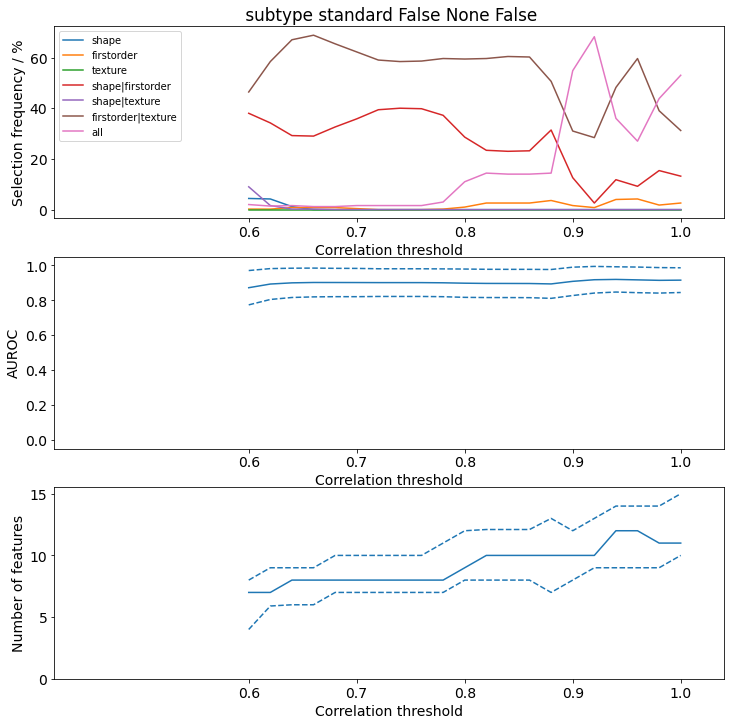

Threshold = 0.94
AUROC (CV) = 0.91983

Feature group = firstorder|texture



Feature,Frequency,Coef
lesion_original_firstorder_Skewness,99.000,-0.350
lesion_original_firstorder_RootMeanSquared,88.800,-0.422
lesion_original_glcm_ClusterProminence_log,84.200,1.327
lesion_original_gldm_SmallDependenceLowGrayLevelEmphasis,81.800,-1.038
lesion_original_glszm_SmallAreaEmphasis,76.400,0.295
lesion_original_glszm_ZonePercentage,68.000,0.333
lesion_original_glcm_Idmn,66.800,1.015
lesion_original_firstorder_Mean,65.000,-2.877
lesion_original_ngtdm_Strength_log,63.400,-0.469
lesion_original_ngtdm_Contrast,40.000,0.104


train #      = 170 = 117 : 53 (68.8%)
train resub  = 0.963
train CV     = 0.92
test #       = 89 = 76 : 13 (85.4%)
test         = 0.924
test p-value = 1.163937490482284e-06


____________________
Experiment number 1
Target      subtype
Features    Standard radiomics features + volume fraction
Remove TU   False
Replace TU  None
Remove RX   False
_____________________
.....................


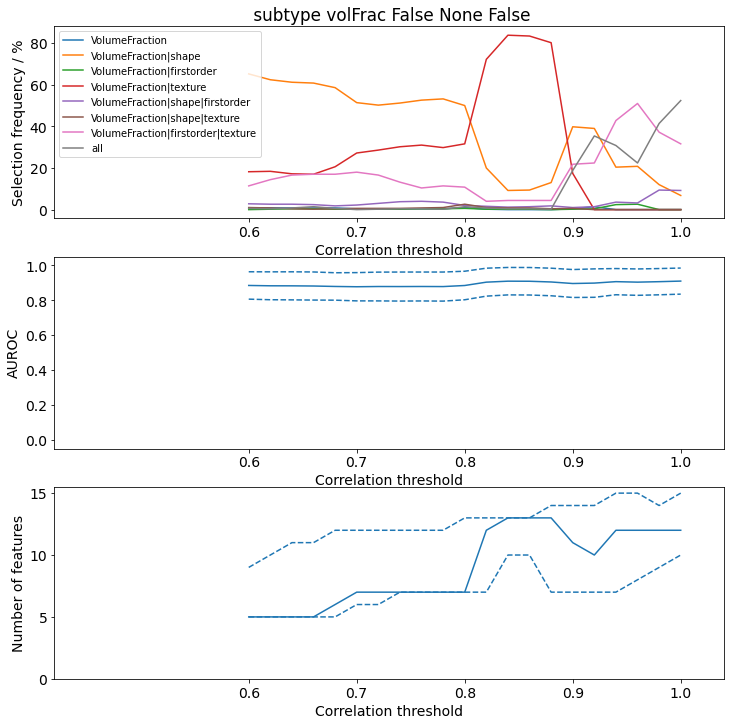

Threshold = 1.0
AUROC (CV) = 0.91022

Feature group = all



Feature,Frequency,Coef
lesion_original_firstorder_RootMeanSquared,92.800,-0.439
lesion_original_firstorder_10Percentile,89.600,-1.372
lesion_original_glcm_Idmn,84.000,0.676
lesion_original_gldm_SmallDependenceLowGrayLevelEmphasis,83.400,-0.387
lesion_original_glcm_ClusterProminence_log,82.800,0.515
lesion_original_firstorder_Skewness,81.800,-0.103
lesion_original_firstorder_Median,79.000,-0.554
lesion_original_shape_Elongation,67.600,-0.294
lesion_original_glszm_SizeZoneNonUniformityNormalized,67.600,0.098
lesion_sarcomaFeature_high enhancingVolumeFraction,64.400,-0.061


train #      = 170 = 117 : 53 (68.8%)
train resub  = 0.958
train CV     = 0.91
test #       = 89 = 76 : 13 (85.4%)
test         = 0.926
test p-value = 1.0347416215106075e-06


____________________
Experiment number 2
Target      subtype
Features    Standard radiomics features + approximate volume fraction
Remove TU   False
Replace TU  None
Remove RX   False
_____________________
.....................


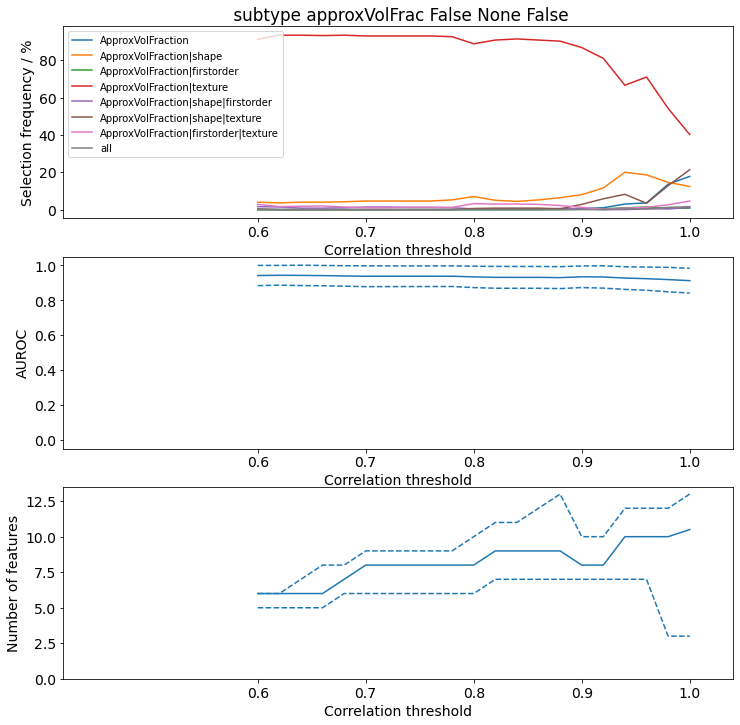

Threshold = 0.62
AUROC (CV) = 0.94354

Feature group = ApproxVolFraction|texture



Feature,Frequency,Coef
lesion_sarcomaFeature_calcApproxVolFraction,99.800,0.662
lesion_original_gldm_SmallDependenceLowGrayLevelEmphasis,95.000,-2.411
lesion_original_glszm_SmallAreaEmphasis,94.800,0.373
lesion_sarcomaFeature_highApproxVolFraction,94.000,-4.782
lesion_original_ngtdm_Strength_log,89.600,0.208
lesion_original_gldm_DependenceNonUniformityNormalized_log,89.400,0.129


train #      = 170 = 117 : 53 (68.8%)
train resub  = 0.957
train CV     = 0.944
test #       = 89 = 76 : 13 (85.4%)
test         = 0.928
test p-value = 9.194067936547276e-07


____________________
Experiment number 3
Target      Grade_1_234
Features    Standard radiomics features
Remove TU   False
Replace TU  None
Remove RX   False
_____________________
.....................


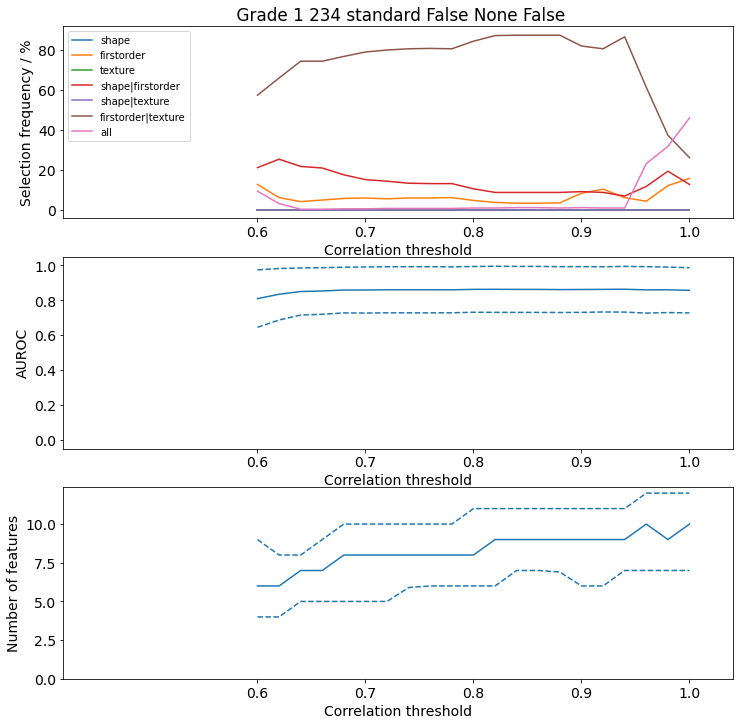

Threshold = 0.94
AUROC (CV) = 0.86348

Feature group = firstorder|texture



Feature,Frequency,Coef
lesion_original_firstorder_90Percentile,100.000,-1.811
lesion_original_firstorder_RootMeanSquared,88.600,0.093
lesion_original_gldm_DependenceNonUniformityNormalized_log,86.600,-0.369
lesion_original_glszm_ZoneVariance_log,83.400,-0.412
lesion_original_glcm_ClusterShade_log,80.800,0.192
lesion_original_ngtdm_Strength_log,74.600,0.136
lesion_original_firstorder_Kurtosis_log,71.600,0.141
lesion_original_glszm_LargeAreaHighGrayLevelEmphasis_log,51.000,-0.070
lesion_original_firstorder_InterquartileRange,49.400,-0.016


train #      = 170 = 132 : 38 (77.6%)
train resub  = 0.909
train CV     = 0.863
test #       = 89 = 56 : 33 (62.9%)
test         = 0.824
test p-value = 3.8701410013537203e-07


____________________
Experiment number 4
Target      Grade_1_234
Features    Standard radiomics features + volume fraction
Remove TU   False
Replace TU  None
Remove RX   False
_____________________
.....................


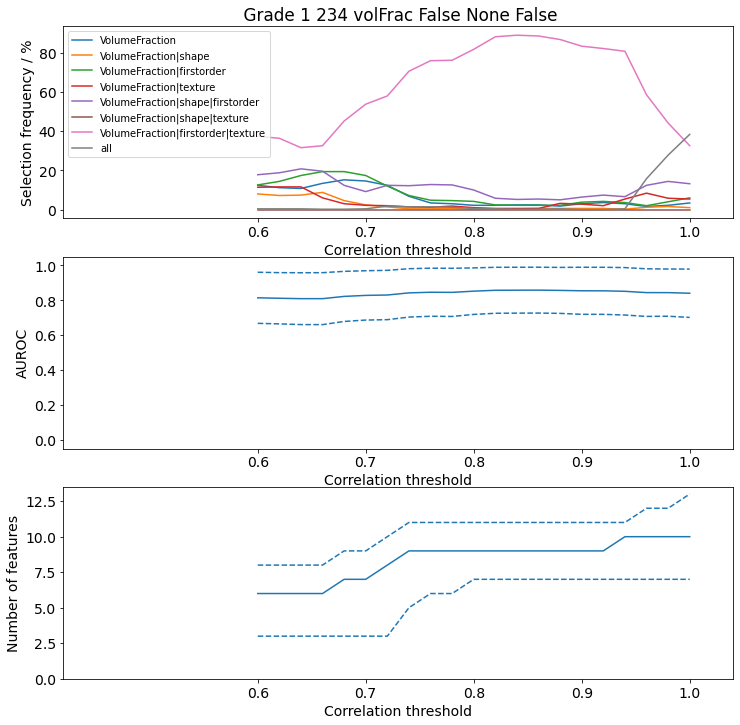

Threshold = 0.86
AUROC (CV) = 0.85834

Feature group = VolumeFraction|firstorder|texture



Feature,Frequency,Coef
lesion_sarcomaFeature_low enhancingVolumeFraction,90.600,0.405
lesion_original_firstorder_90Percentile,90.400,-1.449
lesion_original_gldm_DependenceNonUniformityNormalized_log,89.000,-0.392
lesion_original_firstorder_Kurtosis_log,87.400,0.370
lesion_original_glszm_ZoneVariance_log,83.400,-0.471
lesion_original_glszm_LargeAreaHighGrayLevelEmphasis_log,67.600,-0.114
lesion_original_firstorder_InterquartileRange,61.000,-0.011
lesion_original_firstorder_RootMeanSquared,51.800,0.001


train #      = 170 = 132 : 38 (77.6%)
train resub  = 0.905
train CV     = 0.858
test #       = 89 = 56 : 33 (62.9%)
test         = 0.825
test p-value = 3.5388605632964065e-07


____________________
Experiment number 5
Target      Grade_1_234
Features    Standard radiomics features + approximate volume fraction
Remove TU   False
Replace TU  None
Remove RX   False
_____________________
.....................


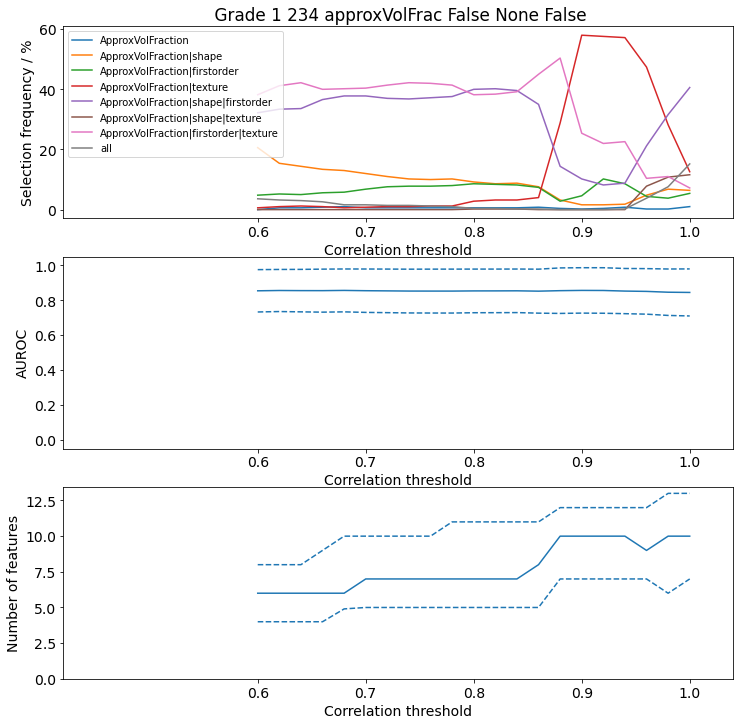

Threshold = 0.9
AUROC (CV) = 0.85678

Feature group = ApproxVolFraction|texture



Feature,Frequency,Coef
lesion_sarcomaFeature_highApproxVolFraction,96.200,-2.066
lesion_original_gldm_DependenceNonUniformityNormalized_log,83.200,-0.505
lesion_original_ngtdm_Strength_log,79.800,0.423
lesion_original_glszm_LargeAreaHighGrayLevelEmphasis_log,73.600,-0.367
lesion_original_glszm_ZoneVariance_log,68.400,-0.231
lesion_original_glcm_MaximumProbability,60.800,1.016
lesion_original_glszm_ZonePercentage,56.800,0.273
lesion_sarcomaFeature_calcApproxVolFraction,52.000,0.019
lesion_sarcomaFeature_lowApproxVolFraction,47.200,0.090
lesion_original_glcm_Imc2,46.200,-0.087


train #      = 170 = 132 : 38 (77.6%)
train resub  = 0.914
train CV     = 0.857
test #       = 89 = 56 : 33 (62.9%)
test         = 0.802
test p-value = 2.0957410113186948e-06


____________________
Experiment number 6
Target      Grade_12_34
Features    Standard radiomics features
Remove TU   False
Replace TU  None
Remove RX   False
_____________________
.....................


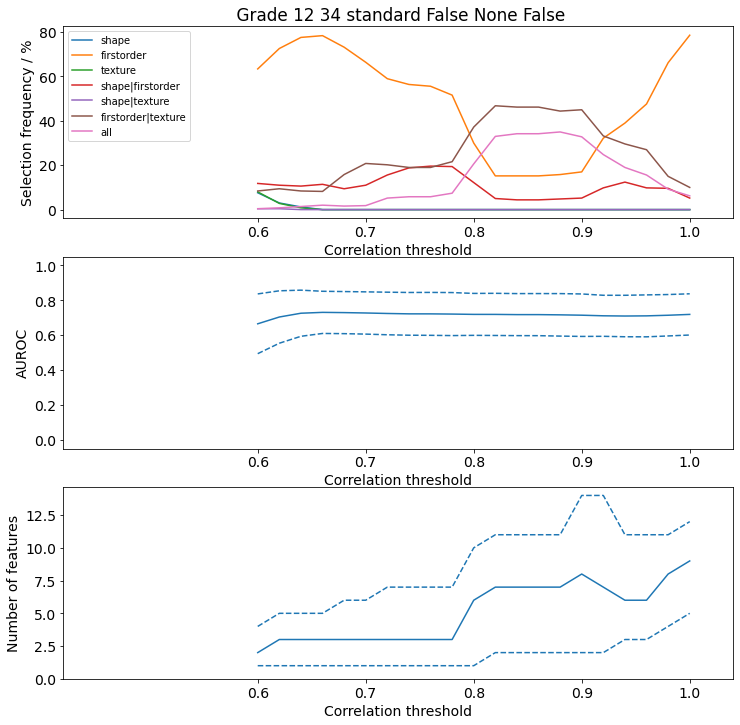

Threshold = 0.66
AUROC (CV) = 0.73089

Feature group = firstorder



Feature,Frequency,Coef
lesion_original_firstorder_90Percentile,92.800,-1.089
lesion_original_firstorder_InterquartileRange,46.800,-0.024
lesion_original_firstorder_Skewness,42.200,0.032


train #      = 170 = 58 : 112 (34.1%)
train resub  = 0.758
train CV     = 0.731
test #       = 89 = 23 : 66 (25.8%)
test         = 0.54
test p-value = not computed


____________________
Experiment number 7
Target      Grade_12_34
Features    Standard radiomics features + volume fraction
Remove TU   False
Replace TU  None
Remove RX   False
_____________________
.....................


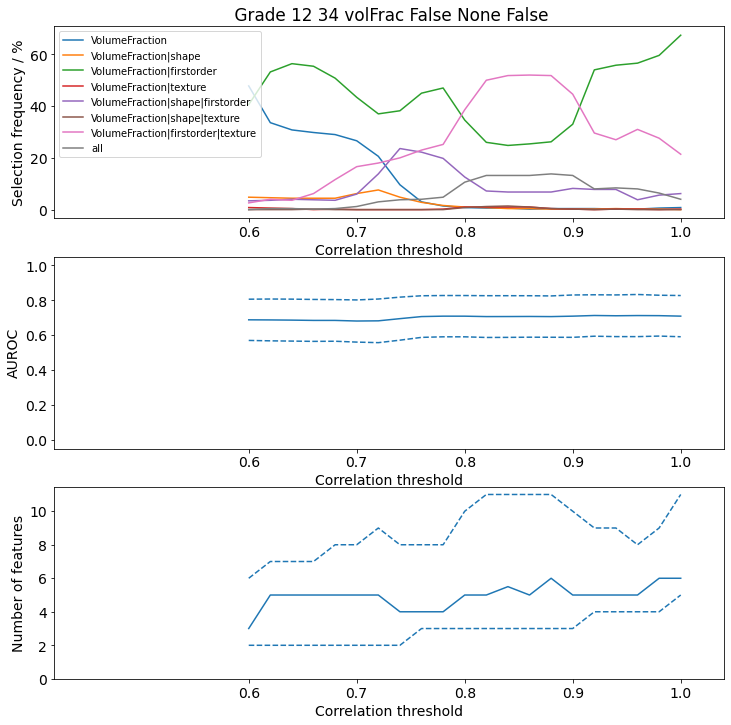

Threshold = 0.92
AUROC (CV) = 0.71298

Feature group = VolumeFraction|shape|firstorder



Feature,Frequency,Coef
lesion_sarcomaFeature_high enhancingVolumeFraction,99.800,-0.373
lesion_original_firstorder_90Percentile,94.400,-0.657
lesion_original_firstorder_InterquartileRange,65.200,-0.062
lesion_original_firstorder_TotalEnergy_log,64.400,-0.131
lesion_original_shape_Flatness,15.600,-0.069


train #      = 170 = 58 : 112 (34.1%)
train resub  = 0.77
train CV     = 0.713
test #       = 89 = 23 : 66 (25.8%)
test         = 0.512
test p-value = not computed


____________________
Experiment number 8
Target      Grade_12_34
Features    Standard radiomics features + approximate volume fraction
Remove TU   False
Replace TU  None
Remove RX   False
_____________________
.....................


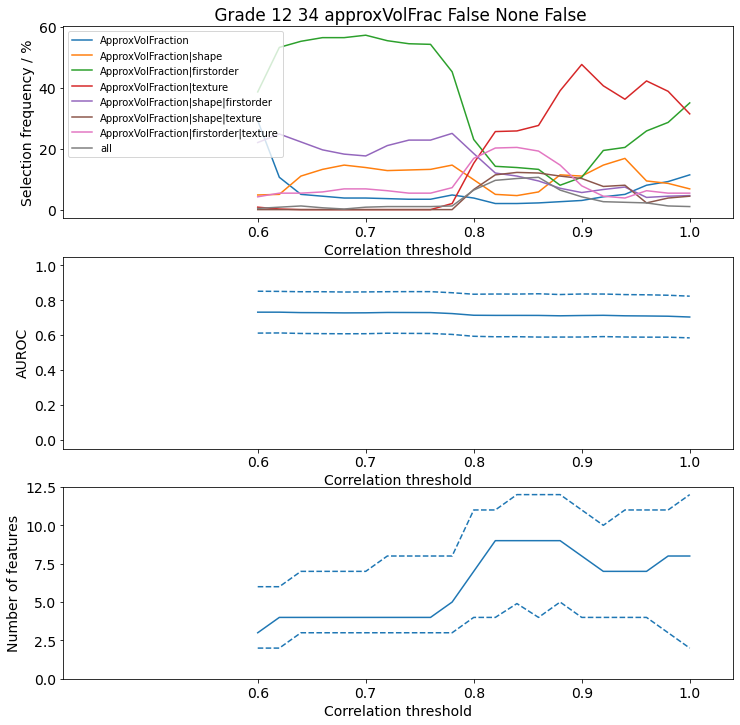

Threshold = 0.62
AUROC (CV) = 0.73203

Feature group = ApproxVolFraction|firstorder



Feature,Frequency,Coef
lesion_sarcomaFeature_highApproxVolFraction,94.800,-1.144
lesion_sarcomaFeature_calcApproxVolFraction,88.800,0.096
lesion_original_firstorder_InterquartileRange,80.600,-0.485


train #      = 170 = 58 : 112 (34.1%)
train resub  = 0.78
train CV     = 0.732
test #       = 89 = 23 : 66 (25.8%)
test         = 0.571
test p-value = not computed


____________________
Experiment number 9
Target      overall_survival
Features    Standard radiomics features + volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


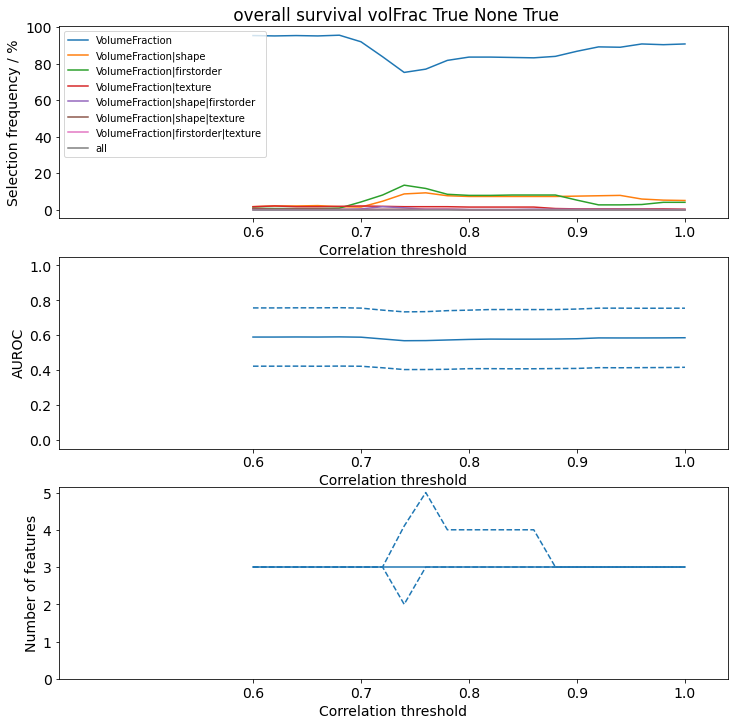

Threshold = 0.68
AUROC (CV) = 0.59033

Feature group = VolumeFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_low enhancingVolumeFraction,99.800,0.654
lesion_sarcomaFeature_calcificationVolumeFraction,99.400,-0.060
lesion_sarcomaFeature_mid enhancingVolumeFraction,98.200,0.107


train #      = 145 = 21 : 124 (14.5%)
train resub  = 0.655
train CV     = 0.59
test #       = 87 = 5 : 82 (5.7%)
test         = 0.583
test p-value = not computed


____________________
Experiment number 10
Target      overall_survival
Features    Standard radiomics features + volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


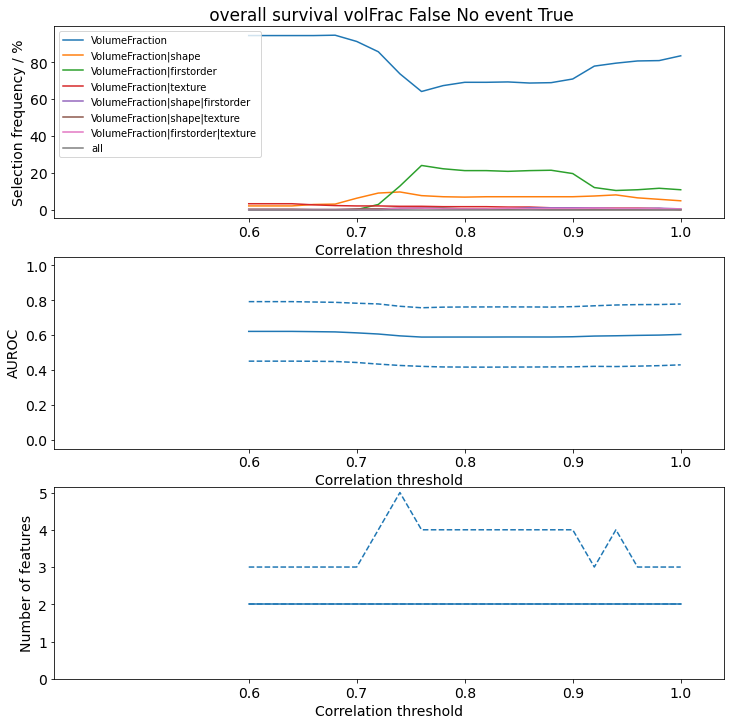

Threshold = 0.6
AUROC (CV) = 0.62181

Feature group = VolumeFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_low enhancingVolumeFraction,100.000,0.668
lesion_sarcomaFeature_mid enhancingVolumeFraction,99.200,0.118


train #      = 167 = 21 : 146 (12.6%)
train resub  = 0.662
train CV     = 0.622
test #       = 89 = 5 : 84 (5.6%)
test         = 0.626
test p-value = 0.34195268439942106


____________________
Experiment number 11
Target      overall_survival
Features    Standard radiomics features + approximate volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


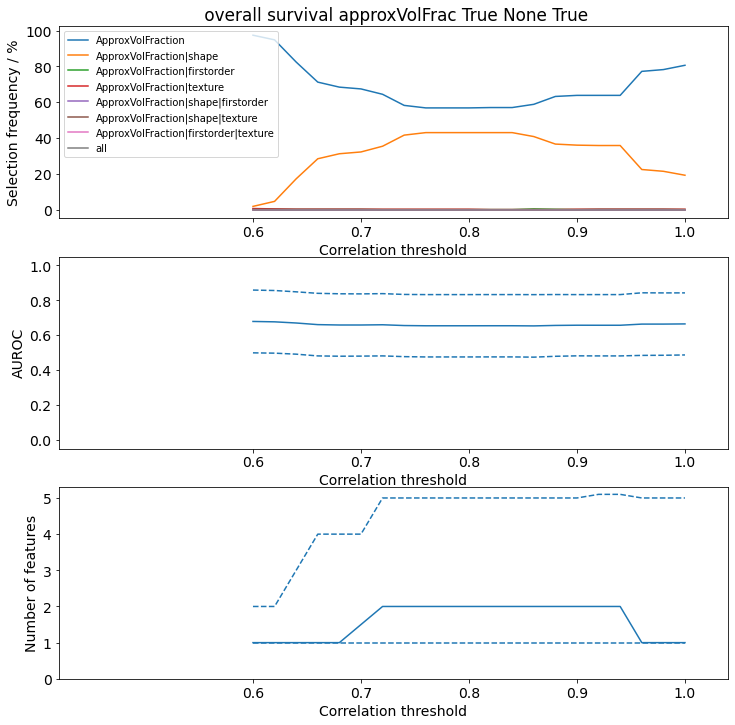

Threshold = 0.6
AUROC (CV) = 0.67879

Feature group = ApproxVolFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_highApproxVolFraction,92.200,-0.768


train #      = 145 = 21 : 124 (14.5%)
train resub  = 0.712
train CV     = 0.679
test #       = 87 = 5 : 82 (5.7%)
test         = 0.656
test p-value = 0.24683952723361147


____________________
Experiment number 12
Target      overall_survival
Features    Standard radiomics features + approximate volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


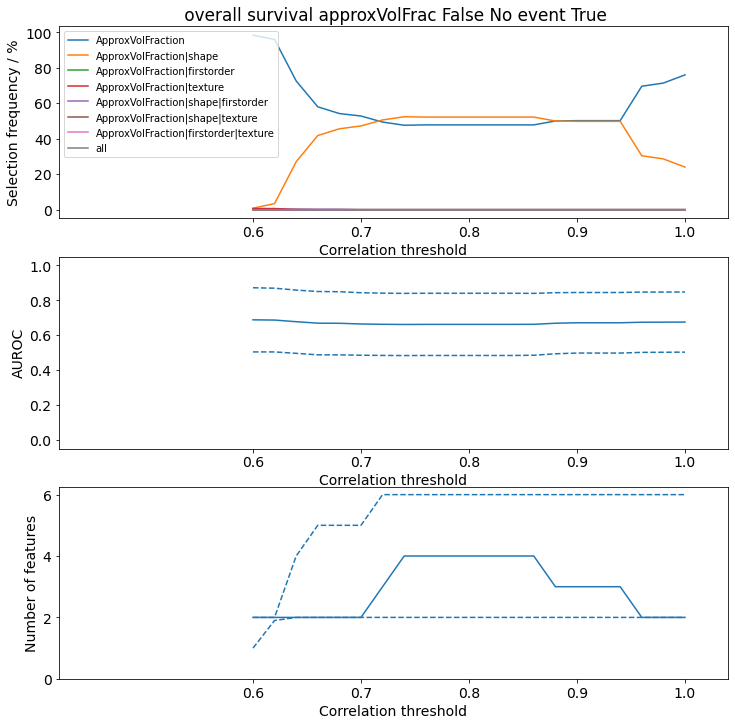

Threshold = 0.6
AUROC (CV) = 0.68813

Feature group = ApproxVolFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_highApproxVolFraction,92.200,-0.956
lesion_sarcomaFeature_calcApproxVolFraction,89.400,0.024


train #      = 167 = 21 : 146 (12.6%)
train resub  = 0.72
train CV     = 0.688
test #       = 89 = 5 : 84 (5.6%)
test         = 0.652
test p-value = 0.2578842792219328


____________________
Experiment number 13
Target      overall_survival
Features    Clinical + standard radiomics features + volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


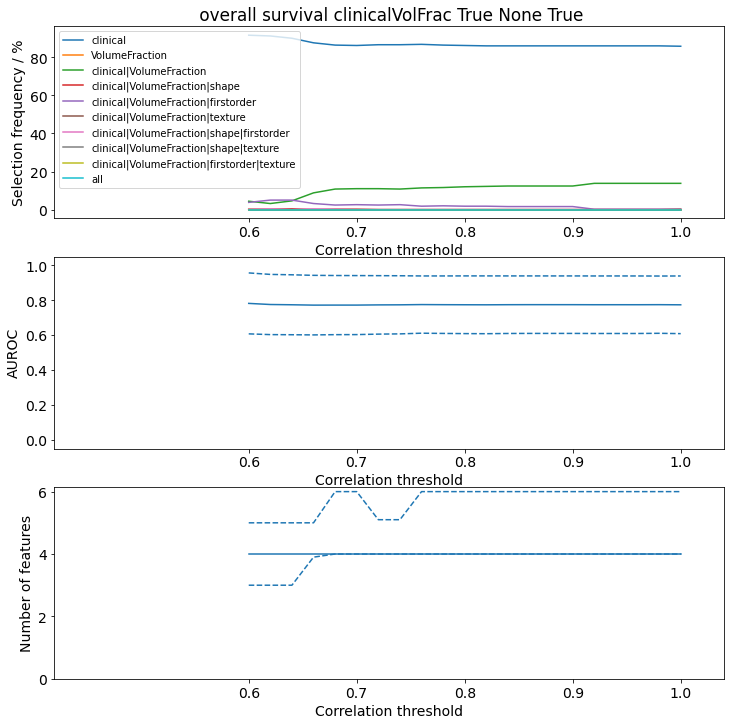

Threshold = 0.6
AUROC (CV) = 0.78236

Feature group = clinical



Feature,Frequency,Coef
clinical_Grade,100.000,-1.377
clinical_ECOG,100.000,-0.369
clinical_Sex,99.400,-0.239


train #      = 145 = 21 : 124 (14.5%)
train resub  = 0.834
train CV     = 0.782
test #       = 87 = 5 : 82 (5.7%)
test         = 0.779
test p-value = 0.03568841865940081


____________________
Experiment number 14
Target      overall_survival
Features    Clinical + standard radiomics features + volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


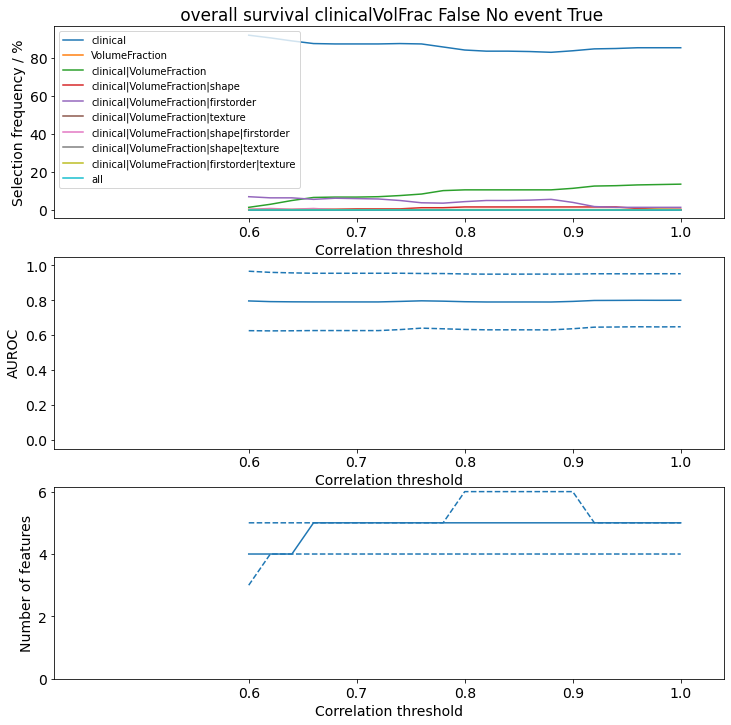

Threshold = 1.0
AUROC (CV) = 0.80032

Feature group = clinical



Feature,Frequency,Coef
clinical_Grade,100.000,-1.094
clinical_ECOG,100.000,-0.333
clinical_Sex,99.200,-0.177
clinical_Size,90.200,0.113


train #      = 167 = 21 : 146 (12.6%)
train resub  = 0.849
train CV     = 0.8
test #       = 89 = 5 : 84 (5.6%)
test         = 0.775
test p-value = 0.0404541613299817


____________________
Experiment number 15
Target      overall_survival
Features    Clinical + standard radiomics features + approximate volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


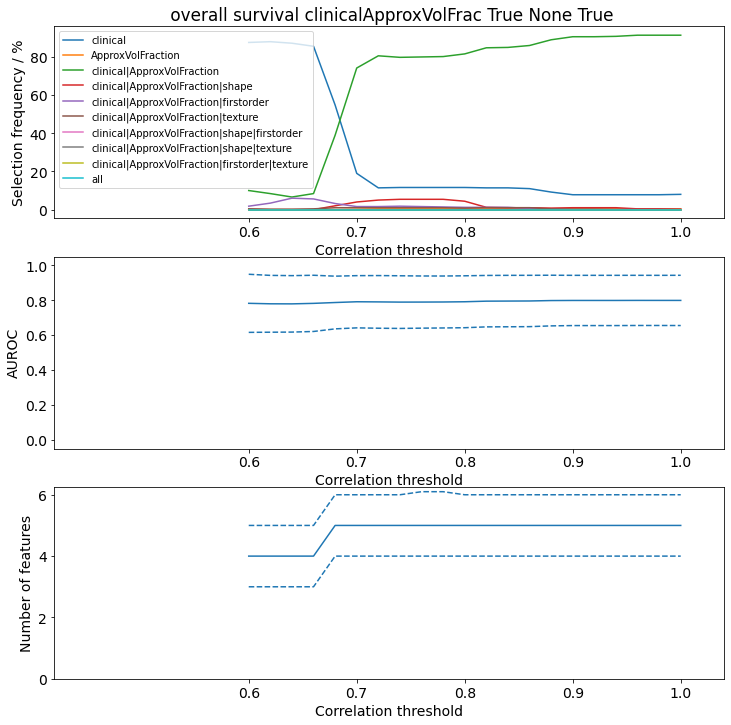

Threshold = 0.96
AUROC (CV) = 0.79951

Feature group = clinical|ApproxVolFraction



Feature,Frequency,Coef
clinical_Grade,99.600,-0.852
clinical_ECOG,99.600,-0.304
clinical_Sex,99.200,-0.200
lesion_sarcomaFeature_highApproxVolFraction,92.200,-0.593
clinical_Subtype,81.600,-0.107


train #      = 145 = 21 : 124 (14.5%)
train resub  = 0.863
train CV     = 0.8
test #       = 87 = 5 : 82 (5.7%)
test         = 0.829
test p-value = 0.01417101731210952


____________________
Experiment number 16
Target      overall_survival
Features    Clinical + standard radiomics features + approximate volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
...........

/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


.

/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


.

/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


.....

/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


.

/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


..


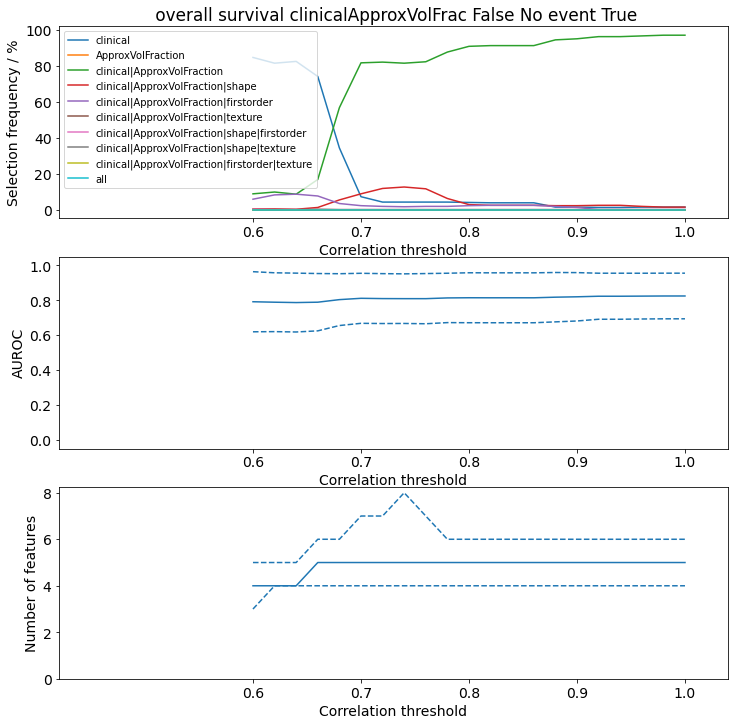

Threshold = 1.0
AUROC (CV) = 0.82482

Feature group = clinical|ApproxVolFraction



Feature,Frequency,Coef
clinical_Grade,100.000,-1.068
clinical_ECOG,100.000,-0.425
clinical_Sex,99.000,-0.236
lesion_sarcomaFeature_highApproxVolFraction,98.600,-0.845
clinical_Subtype,83.000,-0.173


train #      = 167 = 21 : 146 (12.6%)
train resub  = 0.869
train CV     = 0.825
test #       = 89 = 5 : 84 (5.6%)
test         = 0.836
test p-value = 0.012302487142399367


____________________
Experiment number 17
Target      distant_recurrence
Features    Standard radiomics features + volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


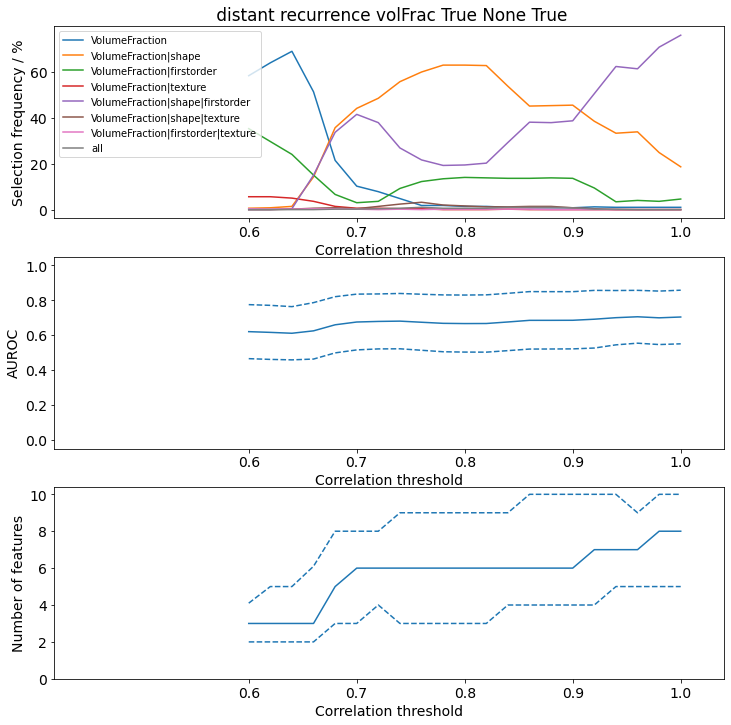

Threshold = 0.96
AUROC (CV) = 0.70567

Feature group = VolumeFraction|shape|firstorder



Feature,Frequency,Coef
lesion_original_shape_Sphericity,95.000,0.764
lesion_original_shape_Flatness,95.000,-0.352
lesion_sarcomaFeature_calcificationVolumeFraction,67.400,-0.009
lesion_original_firstorder_Median,64.600,-1.072
lesion_sarcomaFeature_low enhancingVolumeFraction,58.000,0.024
lesion_original_firstorder_90Percentile,49.600,-0.173
lesion_original_firstorder_Skewness,44.600,0.038
lesion_original_firstorder_Range,39.000,-0.034
lesion_sarcomaFeature_mid enhancingVolumeFraction,34.000,-0.022


train #      = 139 = 28 : 111 (20.1%)
train resub  = 0.821
train CV     = 0.706
test #       = 87 = 12 : 75 (13.8%)
test         = 0.55
test p-value = not computed


____________________
Experiment number 18
Target      distant_recurrence
Features    Standard radiomics features + volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


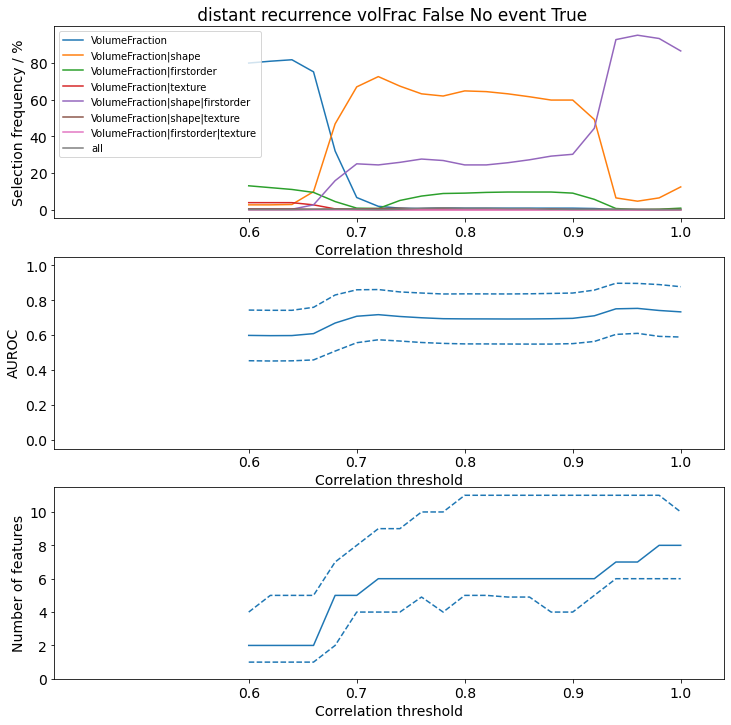

Threshold = 0.96
AUROC (CV) = 0.75376

Feature group = VolumeFraction|shape|firstorder



Feature,Frequency,Coef
lesion_original_shape_Sphericity,100.000,1.243
lesion_original_shape_Flatness,98.400,-0.411
lesion_original_shape_Elongation,82.400,-0.137
lesion_original_firstorder_Mean,73.200,-1.834
lesion_original_firstorder_Skewness,71.000,0.069
lesion_sarcomaFeature_mid enhancingVolumeFraction,68.600,-0.183
lesion_original_firstorder_Range,61.800,-0.354
lesion_sarcomaFeature_calcificationVolumeFraction,35.400,0.009
lesion_sarcomaFeature_low enhancingVolumeFraction,25.200,0.091
lesion_original_firstorder_Maximum,23.200,0.322


train #      = 167 = 28 : 139 (16.8%)
train resub  = 0.846
train CV     = 0.754
test #       = 89 = 12 : 77 (13.5%)
test         = 0.578
test p-value = not computed


____________________
Experiment number 19
Target      distant_recurrence
Features    Standard radiomics features + approximate volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


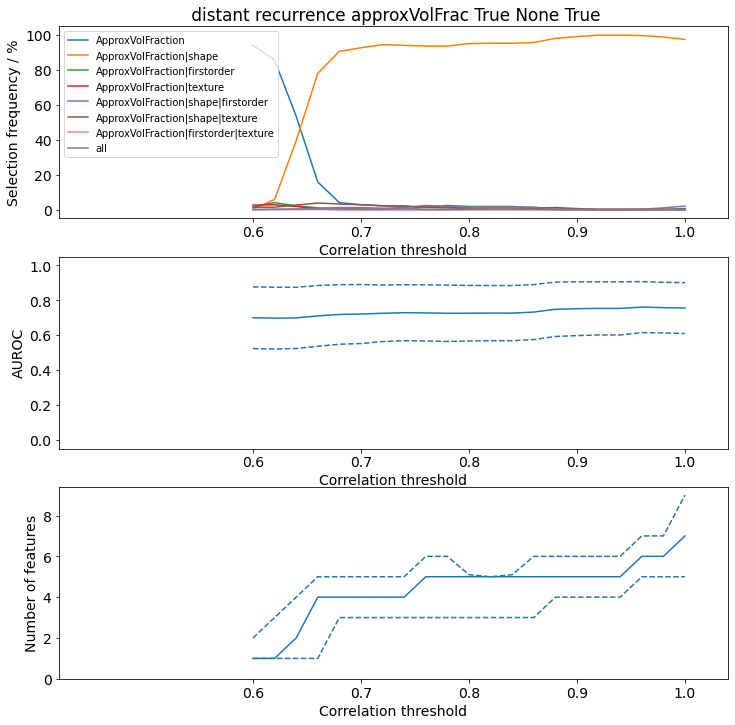

Threshold = 0.96
AUROC (CV) = 0.76102

Feature group = ApproxVolFraction|shape



Feature,Frequency,Coef
lesion_original_shape_Sphericity,100.000,1.176
lesion_sarcomaFeature_highApproxVolFraction,100.000,-0.875
lesion_original_shape_Flatness,100.000,-0.457
lesion_sarcomaFeature_lowApproxVolFraction,99.600,0.944
lesion_original_shape_Elongation,73.000,-0.087
lesion_original_shape_LeastAxisLength,63.200,-0.067


train #      = 139 = 28 : 111 (20.1%)
train resub  = 0.823
train CV     = 0.761
test #       = 87 = 12 : 75 (13.8%)
test         = 0.556
test p-value = not computed


____________________
Experiment number 20
Target      distant_recurrence
Features    Standard radiomics features + approximate volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


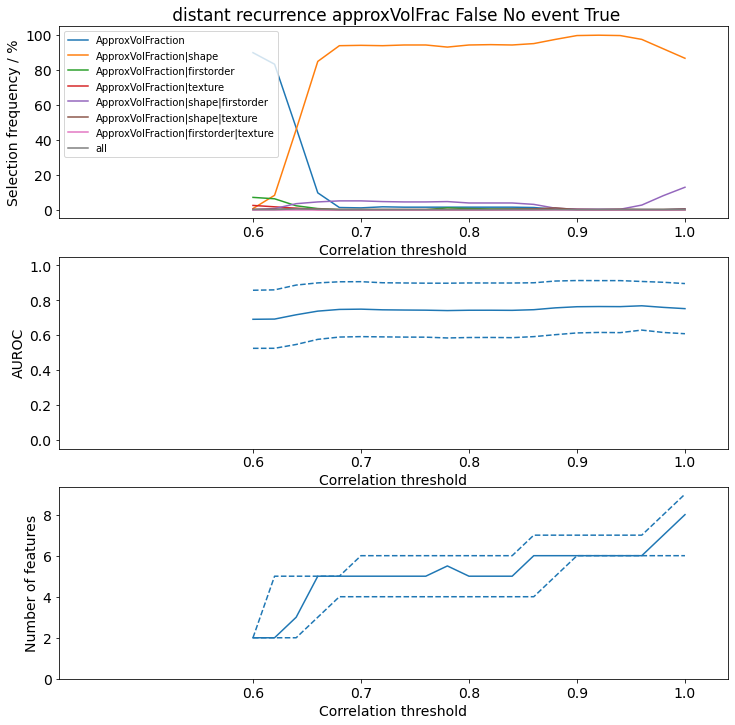

Threshold = 0.96
AUROC (CV) = 0.76864

Feature group = ApproxVolFraction|shape



Feature,Frequency,Coef
lesion_original_shape_Sphericity,100.000,1.234
lesion_original_shape_Flatness,99.800,-0.360
lesion_sarcomaFeature_lowApproxVolFraction,98.000,0.936
lesion_sarcomaFeature_highApproxVolFraction,97.600,-0.931
lesion_sarcomaFeature_calcApproxVolFraction,90.800,0.072
lesion_original_shape_Elongation,89.800,-0.184


train #      = 167 = 28 : 139 (16.8%)
train resub  = 0.823
train CV     = 0.769
test #       = 89 = 12 : 77 (13.5%)
test         = 0.566
test p-value = not computed


____________________
Experiment number 21
Target      distant_recurrence
Features    Clinical + standard radiomics features + volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


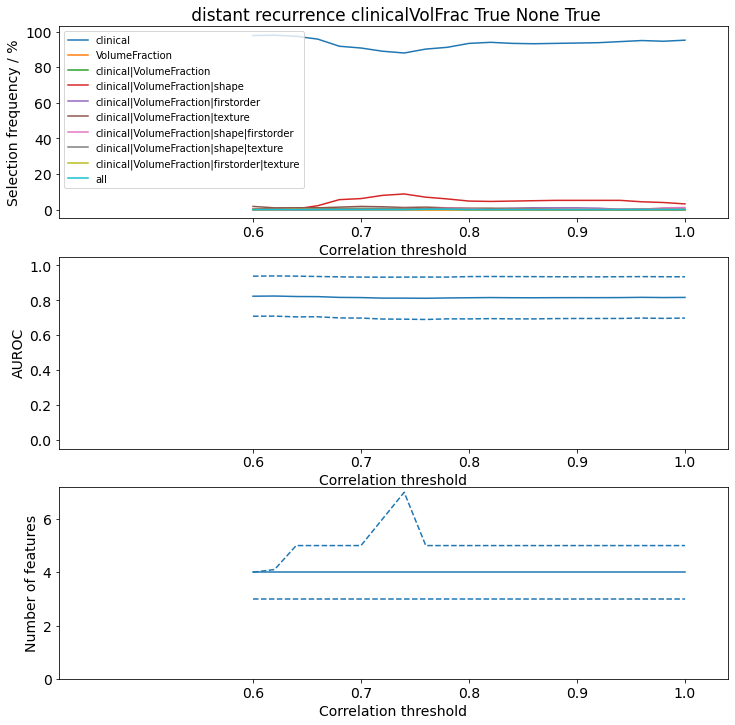

Threshold = 0.62
AUROC (CV) = 0.82454

Feature group = clinical



Feature,Frequency,Coef
clinical_Grade,100.000,-1.247
clinical_Subtype,92.600,0.221
clinical_Sex,92.200,0.111
clinical_ECOG,76.800,-0.076


train #      = 139 = 28 : 111 (20.1%)
train resub  = 0.845
train CV     = 0.825
test #       = 87 = 12 : 75 (13.8%)
test         = 0.654
test p-value = 0.08725023793150634


____________________
Experiment number 22
Target      distant_recurrence
Features    Clinical + standard radiomics features + volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


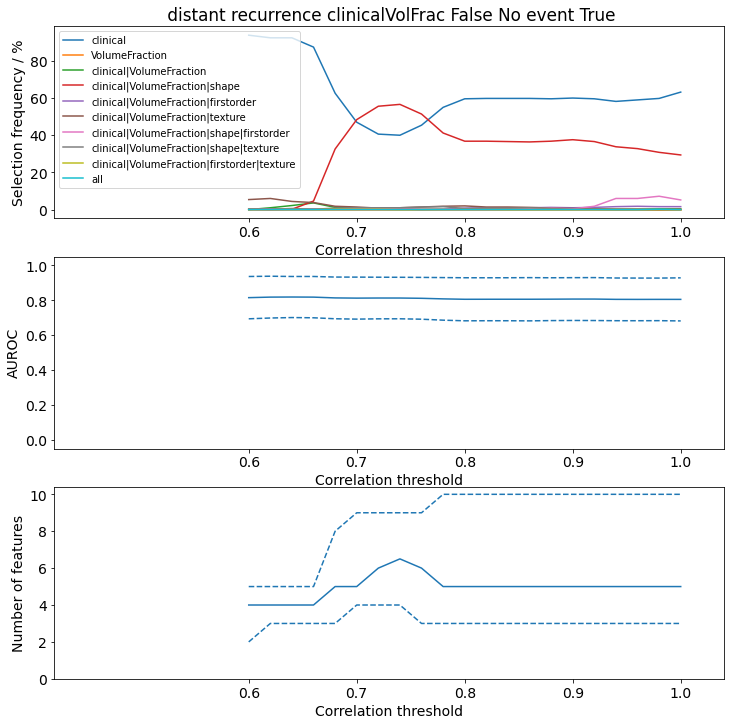

Threshold = 0.64
AUROC (CV) = 0.81888

Feature group = clinical



Feature,Frequency,Coef
clinical_Grade,100.000,-1.398
clinical_Sex,98.600,0.217
clinical_Subtype,97.800,0.349
clinical_ECOG,69.600,-0.096
clinical_Size,26.800,-0.066


train #      = 167 = 28 : 139 (16.8%)
train resub  = 0.846
train CV     = 0.819
test #       = 89 = 12 : 77 (13.5%)
test         = 0.65
test p-value = 0.09615342092889823


____________________
Experiment number 23
Target      distant_recurrence
Features    Clinical + standard radiomics features + approximate volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


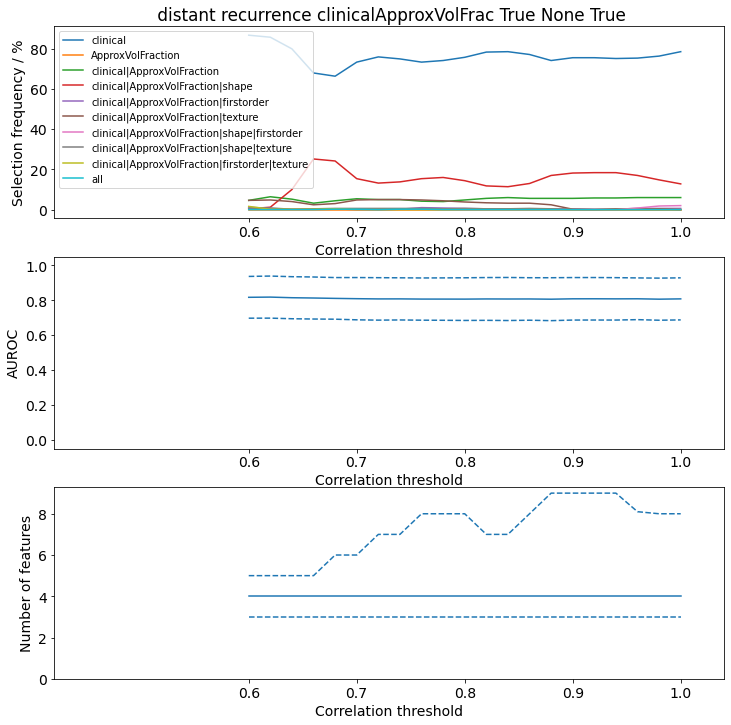

Threshold = 0.62
AUROC (CV) = 0.81844

Feature group = clinical



Feature,Frequency,Coef
clinical_Grade,100.000,-1.247
clinical_Subtype,92.600,0.221
clinical_Sex,92.200,0.111
clinical_ECOG,77.400,-0.076


train #      = 139 = 28 : 111 (20.1%)
train resub  = 0.845
train CV     = 0.818
test #       = 87 = 12 : 75 (13.8%)
test         = 0.654
test p-value = 0.08725023793150634


____________________
Experiment number 24
Target      distant_recurrence
Features    Clinical + standard radiomics features + approximate volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


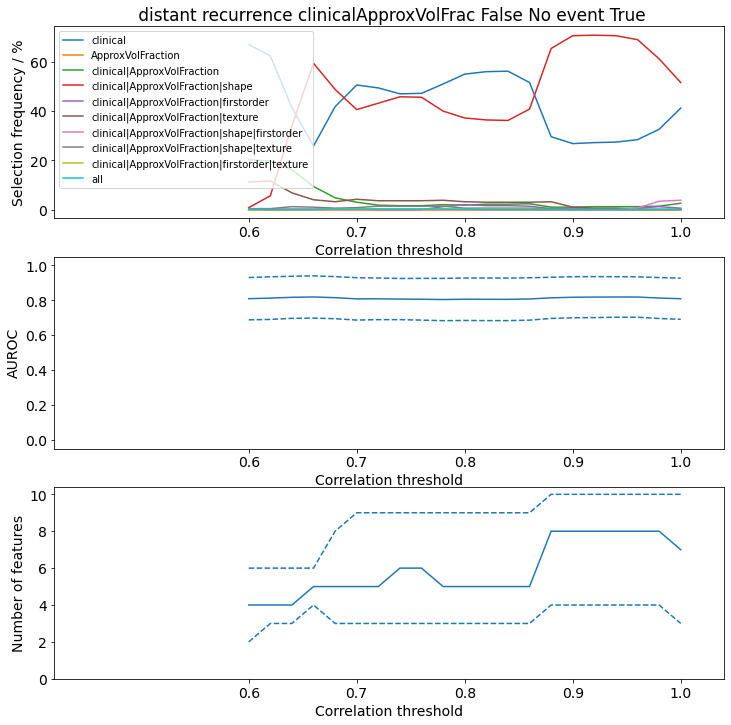

Threshold = 0.66
AUROC (CV) = 0.81922

Feature group = clinical|ApproxVolFraction|shape



Feature,Frequency,Coef
clinical_Grade,100.000,-1.259
clinical_Subtype,99.800,0.416
clinical_Sex,94.200,0.107
clinical_ECOG,68.000,-0.037
lesion_original_shape_Sphericity,60.600,0.349
lesion_original_shape_Elongation,27.200,-0.003


train #      = 167 = 28 : 139 (16.8%)
train resub  = 0.86
train CV     = 0.819
test #       = 89 = 12 : 77 (13.5%)
test         = 0.656
test p-value = 0.08474509620184363


____________________
Experiment number 25
Target      local_recurrence
Features    Standard radiomics features + volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


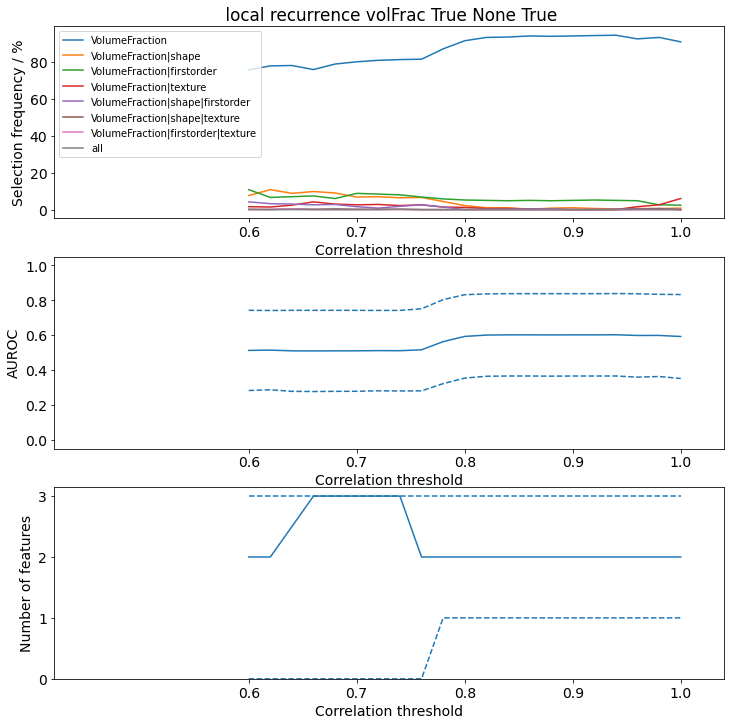

Threshold = 0.94
AUROC (CV) = 0.60246

Feature group = VolumeFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_high enhancingVolumeFraction,99.800,-0.337


train #      = 130 = 16 : 114 (12.3%)
train resub  = 0.624
train CV     = 0.602
test #       = 87 = 12 : 75 (13.8%)
test         = 0.526
test p-value = not computed


____________________
Experiment number 26
Target      local_recurrence
Features    Standard radiomics features + volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


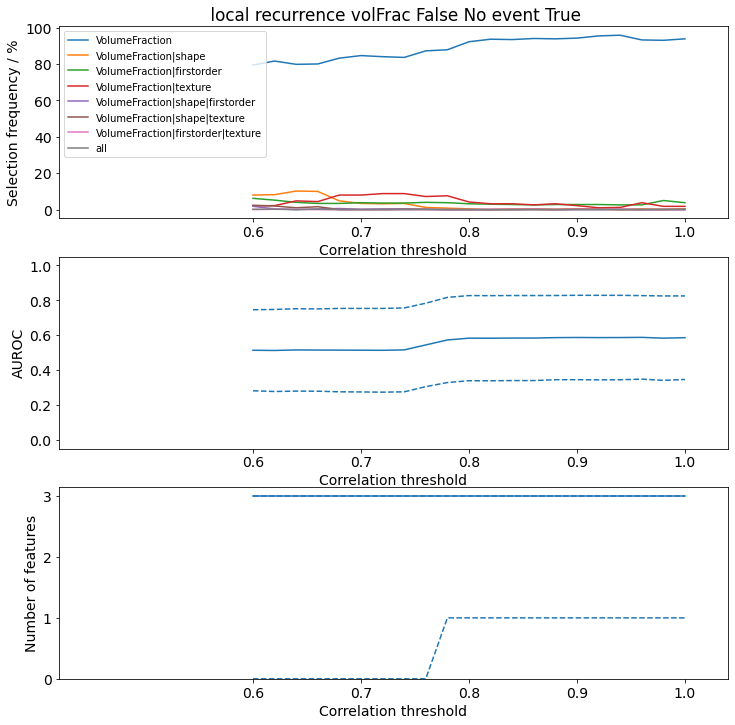

Threshold = 0.96
AUROC (CV) = 0.58754

Feature group = VolumeFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_high enhancingVolumeFraction,98.800,-0.308
lesion_sarcomaFeature_mid enhancingVolumeFraction,64.000,0.005


train #      = 167 = 16 : 151 (9.6%)
train resub  = 0.624
train CV     = 0.588
test #       = 89 = 12 : 77 (13.5%)
test         = 0.524
test p-value = not computed


____________________
Experiment number 27
Target      local_recurrence
Features    Standard radiomics features + approximate volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
..............

/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


.......


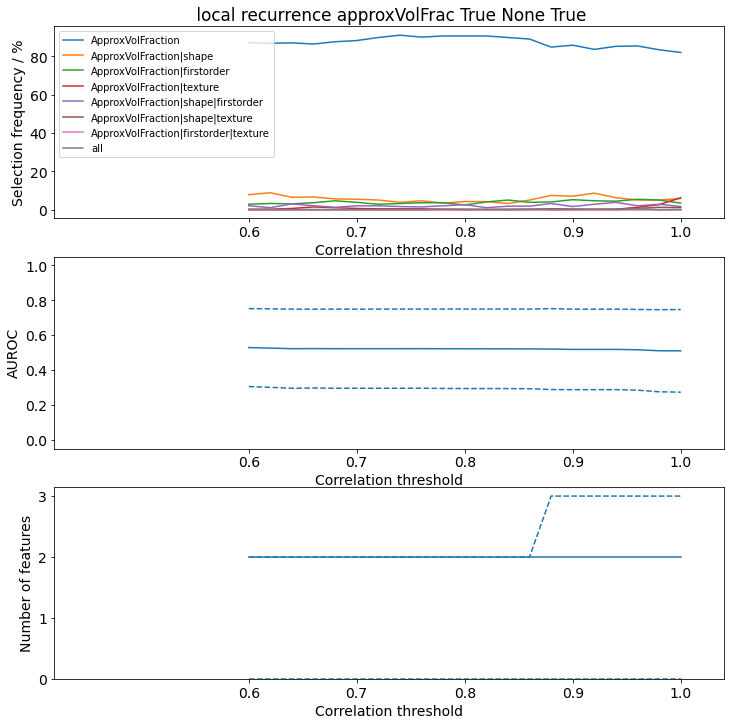

Threshold = 0.6
AUROC (CV) = 0.52892

Feature group = ApproxVolFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_highApproxVolFraction,83.400,-0.368
lesion_sarcomaFeature_calcApproxVolFraction,71.000,0.242


train #      = 130 = 16 : 114 (12.3%)
train resub  = 0.589
train CV     = 0.529
test #       = 87 = 12 : 75 (13.8%)
test         = 0.57
test p-value = not computed


____________________
Experiment number 28
Target      local_recurrence
Features    Standard radiomics features + approximate volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


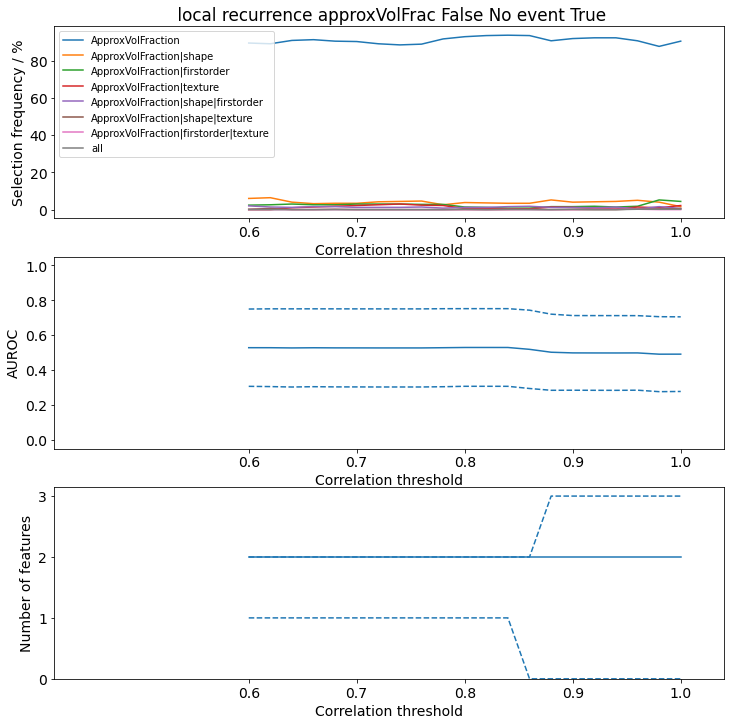

Threshold = 0.82
AUROC (CV) = 0.5296

Feature group = ApproxVolFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_highApproxVolFraction,84.200,-0.186
lesion_sarcomaFeature_calcApproxVolFraction,81.200,0.011


train #      = 167 = 16 : 151 (9.6%)
train resub  = 0.561
train CV     = 0.53
test #       = 89 = 12 : 77 (13.5%)
test         = 0.56
test p-value = not computed


____________________
Experiment number 29
Target      local_recurrence
Features    Clinical + standard radiomics features + volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


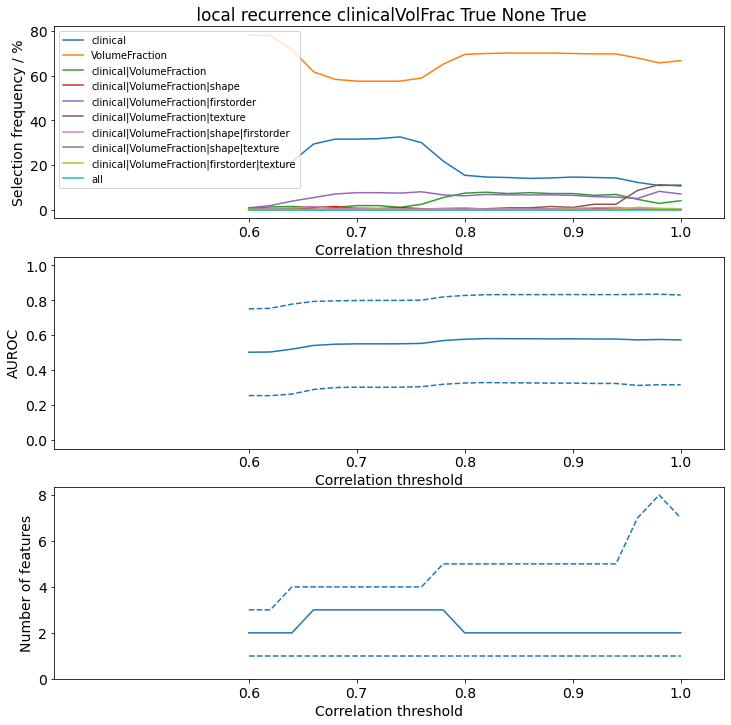

Threshold = 0.82
AUROC (CV) = 0.58042

Feature group = VolumeFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_high enhancingVolumeFraction,82.000,-0.337


train #      = 130 = 16 : 114 (12.3%)
train resub  = 0.624
train CV     = 0.58
test #       = 87 = 12 : 75 (13.8%)
test         = 0.526
test p-value = not computed


____________________
Experiment number 30
Target      local_recurrence
Features    Clinical + standard radiomics features + volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


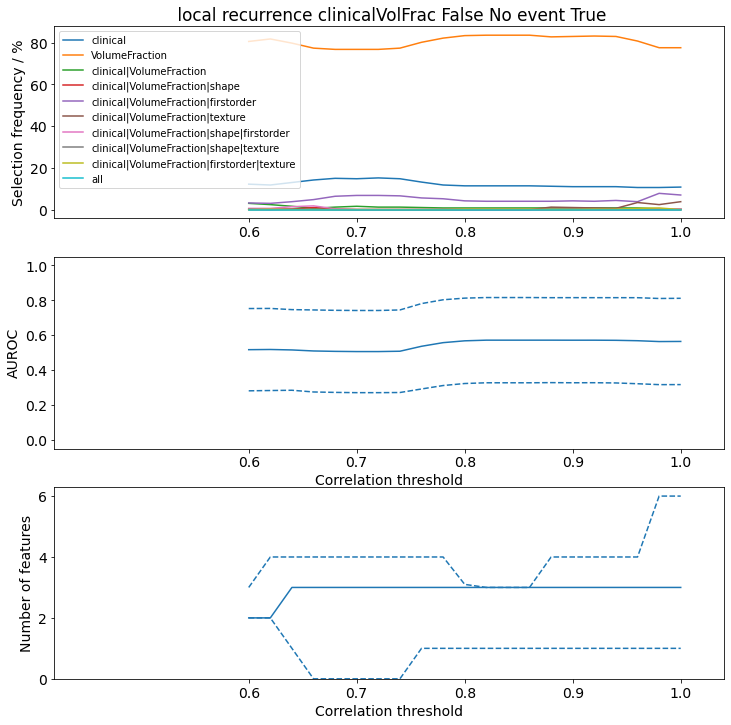

Threshold = 0.88
AUROC (CV) = 0.57156

Feature group = VolumeFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_high enhancingVolumeFraction,87.000,-0.308
lesion_sarcomaFeature_mid enhancingVolumeFraction,63.000,0.005


train #      = 167 = 16 : 151 (9.6%)
train resub  = 0.624
train CV     = 0.572
test #       = 89 = 12 : 77 (13.5%)
test         = 0.524
test p-value = not computed


____________________
Experiment number 31
Target      local_recurrence
Features    Clinical + standard radiomics features + approximate volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....

/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


.

/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


.

/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


.

/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


.

/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


.

/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


.

/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


.

/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


.

/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


.

/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


...

/Users/adminehann/opt/anaconda3/envs/pythonMatt/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


....


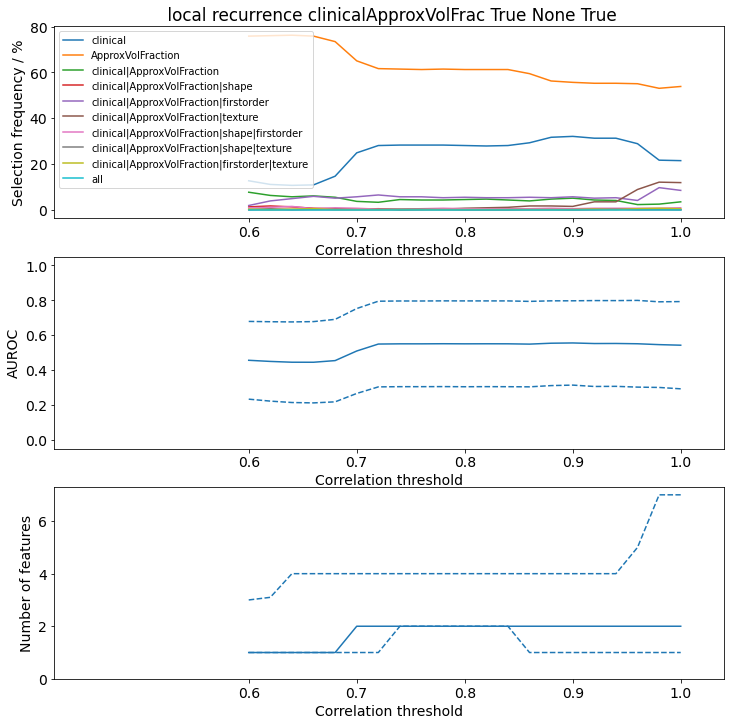

Threshold = 0.9
AUROC (CV) = 0.55555

Feature group = ApproxVolFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_highApproxVolFraction,58.400,-0.320
lesion_sarcomaFeature_calcApproxVolFraction,41.600,0.097


train #      = 130 = 16 : 114 (12.3%)
train resub  = 0.583
train CV     = 0.556
test #       = 87 = 12 : 75 (13.8%)
test         = 0.563
test p-value = not computed


____________________
Experiment number 32
Target      local_recurrence
Features    Clinical + standard radiomics features + approximate volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


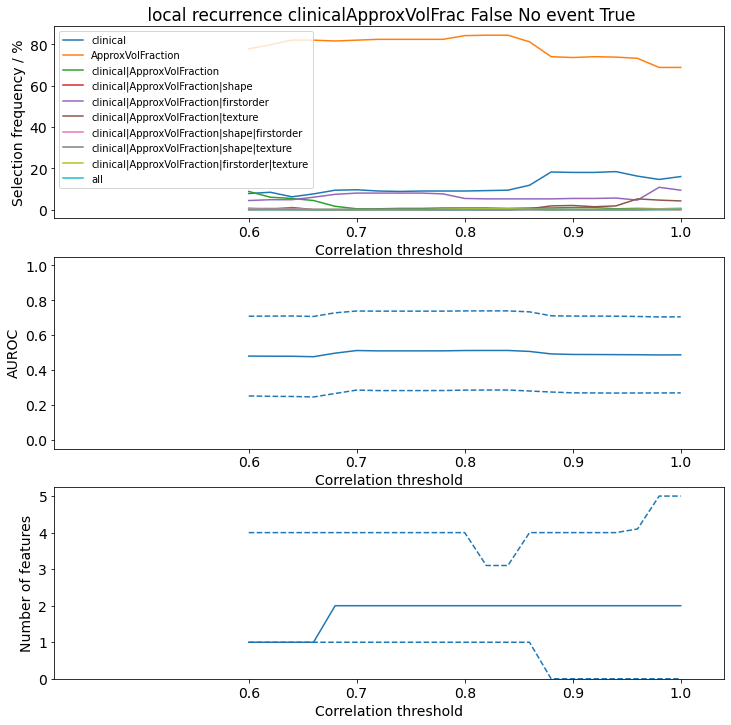

Threshold = 0.82
AUROC (CV) = 0.51248

Feature group = ApproxVolFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_calcApproxVolFraction,73.400,0.011
lesion_sarcomaFeature_highApproxVolFraction,72.800,-0.185


train #      = 167 = 16 : 151 (9.6%)
train resub  = 0.561
train CV     = 0.512
test #       = 89 = 12 : 77 (13.5%)
test         = 0.56
test p-value = not computed


____________________
Experiment number 33
Target      any_recurrence
Features    Standard radiomics features + volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


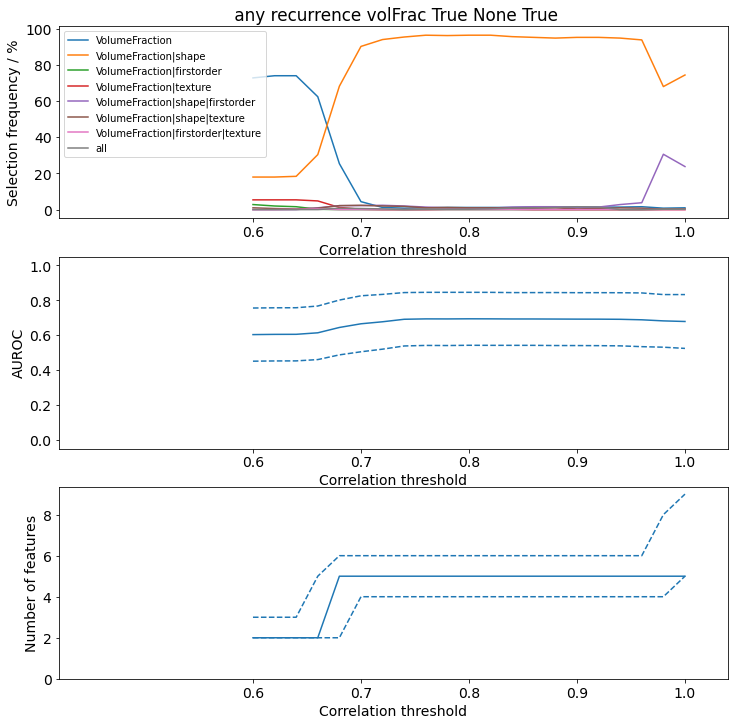

Threshold = 0.8
AUROC (CV) = 0.694

Feature group = VolumeFraction|shape



Feature,Frequency,Coef
lesion_sarcomaFeature_low enhancingVolumeFraction,100.000,0.695
lesion_original_shape_Flatness,98.600,-0.318
lesion_original_shape_Sphericity,98.600,0.781
lesion_sarcomaFeature_high enhancingVolumeFraction,97.400,-0.393
lesion_original_shape_SurfaceVolumeRatio_log,63.600,-0.033


train #      = 142 = 40 : 102 (28.2%)
train resub  = 0.763
train CV     = 0.694
test #       = 79 = 10 : 69 (12.7%)
test         = 0.648
test p-value = 0.1345140716245875


____________________
Experiment number 34
Target      any_recurrence
Features    Standard radiomics features + volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


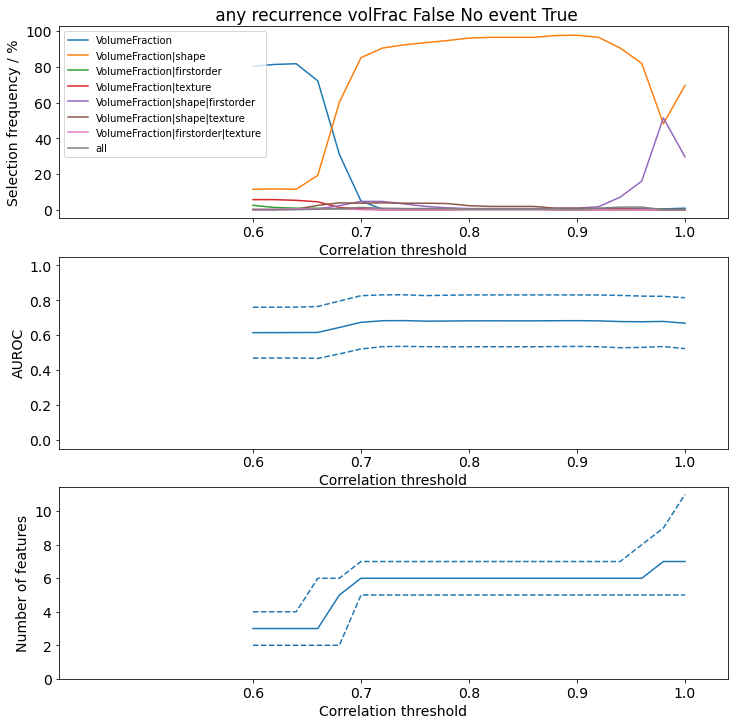

Threshold = 0.74
AUROC (CV) = 0.68369

Feature group = VolumeFraction|shape



Feature,Frequency,Coef
lesion_sarcomaFeature_low enhancingVolumeFraction,100.000,1.017
lesion_original_shape_Sphericity,99.800,0.755
lesion_original_shape_Flatness,97.000,-0.282
lesion_sarcomaFeature_mid enhancingVolumeFraction,94.200,0.192
lesion_original_shape_SurfaceVolumeRatio_log,86.200,-0.078
lesion_sarcomaFeature_calcificationVolumeFraction,85.400,0.030


train #      = 167 = 40 : 127 (24.0%)
train resub  = 0.758
train CV     = 0.684
test #       = 89 = 10 : 79 (11.2%)
test         = 0.654
test p-value = 0.11446120561415048


____________________
Experiment number 35
Target      any_recurrence
Features    Standard radiomics features + approximate volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


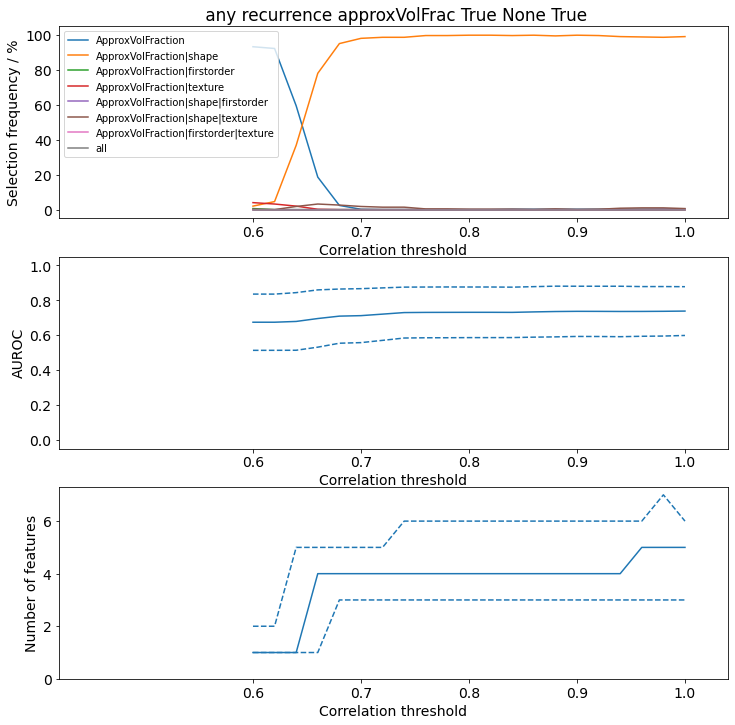

Threshold = 1.0
AUROC (CV) = 0.73829

Feature group = ApproxVolFraction|shape



Feature,Frequency,Coef
lesion_sarcomaFeature_highApproxVolFraction,100.000,-1.080
lesion_original_shape_Sphericity,99.800,0.871
lesion_original_shape_Flatness,99.800,-0.326
lesion_sarcomaFeature_lowApproxVolFraction,61.200,0.071
lesion_sarcomaFeature_calcApproxVolFraction,41.000,0.005
lesion_original_shape_Maximum2DDiameterSlice,34.200,-0.025


train #      = 142 = 40 : 102 (28.2%)
train resub  = 0.784
train CV     = 0.738
test #       = 79 = 10 : 69 (12.7%)
test         = 0.696
test p-value = 0.047356896036890875


____________________
Experiment number 36
Target      any_recurrence
Features    Standard radiomics features + approximate volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


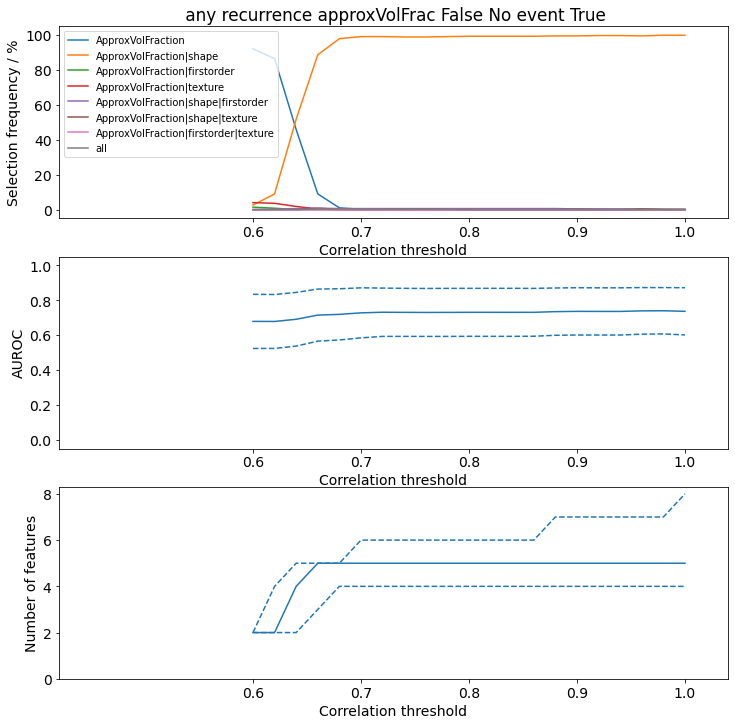

Threshold = 0.98
AUROC (CV) = 0.74016

Feature group = ApproxVolFraction|shape



Feature,Frequency,Coef
lesion_original_shape_Sphericity,100.000,0.865
lesion_sarcomaFeature_highApproxVolFraction,100.000,-1.124
lesion_original_shape_Flatness,99.400,-0.285
lesion_sarcomaFeature_calcApproxVolFraction,92.800,0.076
lesion_sarcomaFeature_lowApproxVolFraction,58.000,0.036


train #      = 167 = 40 : 127 (24.0%)
train resub  = 0.78
train CV     = 0.74
test #       = 89 = 10 : 79 (11.2%)
test         = 0.699
test p-value = 0.04203701913482783


____________________
Experiment number 37
Target      any_recurrence
Features    Clinical + standard radiomics features + volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


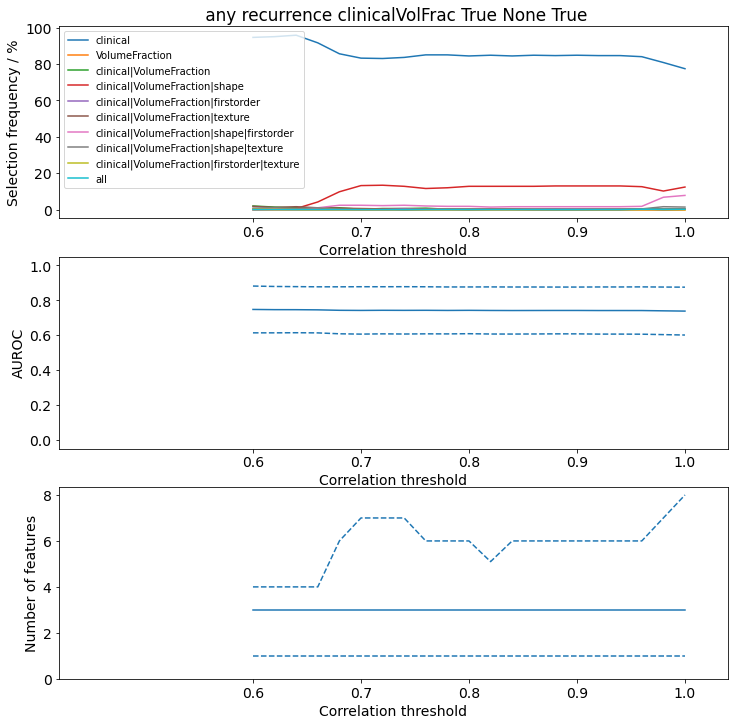

Threshold = 0.6
AUROC (CV) = 0.74766

Feature group = clinical



Feature,Frequency,Coef
clinical_Grade,100.000,-0.932


train #      = 142 = 40 : 102 (28.2%)
train resub  = 0.774
train CV     = 0.748
test #       = 79 = 10 : 69 (12.7%)
test         = 0.604
test p-value = 0.26565136637812525


____________________
Experiment number 38
Target      any_recurrence
Features    Clinical + standard radiomics features + volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


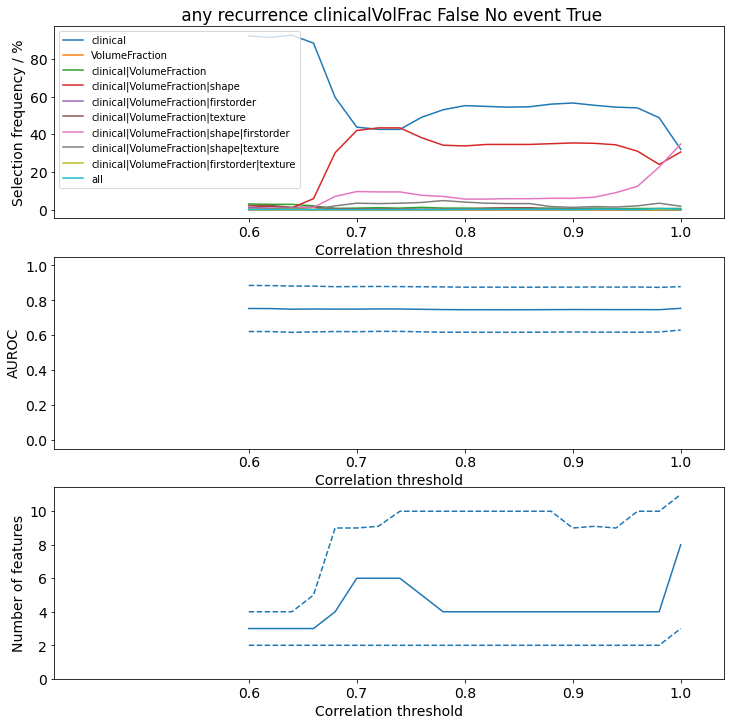

Threshold = 1.0
AUROC (CV) = 0.75407

Feature group = clinical|VolumeFraction|shape|firstorder



Feature,Frequency,Coef
clinical_Grade,100.000,-1.130
clinical_ECOG,71.000,-0.072
lesion_original_shape_Sphericity,67.400,0.872
lesion_original_shape_MajorAxisLength,62.800,0.252
lesion_original_shape_Flatness,37.800,-0.093
lesion_original_firstorder_MeanAbsoluteDeviation,33.400,0.343
lesion_original_firstorder_10Percentile,32.600,-0.352
lesion_original_firstorder_Skewness,18.800,0.032
lesion_original_firstorder_Maximum,13.400,0.023


train #      = 167 = 40 : 127 (24.0%)
train resub  = 0.854
train CV     = 0.754
test #       = 89 = 10 : 79 (11.2%)
test         = 0.649
test p-value = 0.12688811895074834


____________________
Experiment number 39
Target      any_recurrence
Features    Clinical + standard radiomics features + approximate volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


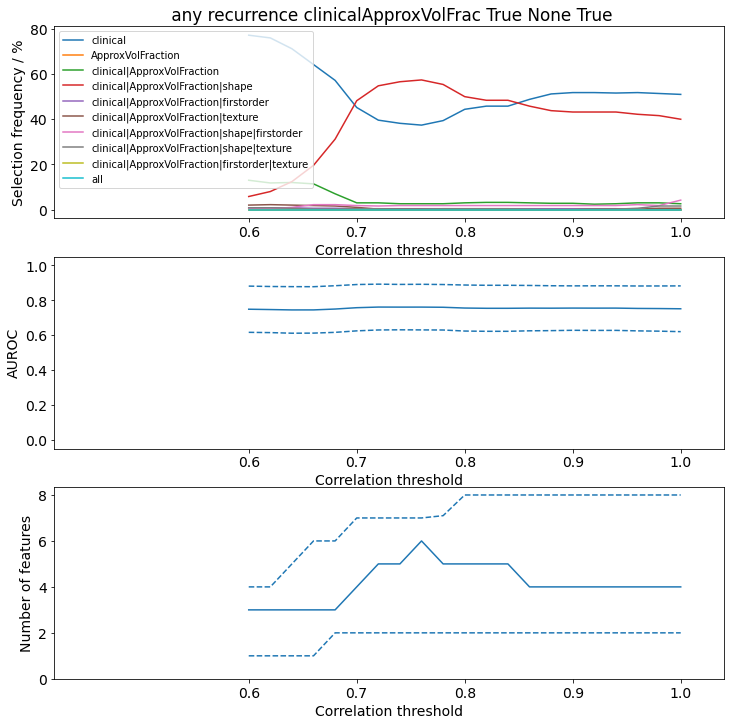

Threshold = 0.72
AUROC (CV) = 0.7613

Feature group = clinical|ApproxVolFraction|shape



Feature,Frequency,Coef
clinical_Grade,100.000,-1.004
clinical_ECOG,81.600,-0.122
lesion_sarcomaFeature_highApproxVolFraction,59.200,-0.651
lesion_original_shape_Sphericity,56.800,0.679
lesion_sarcomaFeature_calcApproxVolFraction,45.600,0.163
lesion_original_shape_Elongation,17.200,-0.020


train #      = 142 = 40 : 102 (28.2%)
train resub  = 0.842
train CV     = 0.761
test #       = 79 = 10 : 69 (12.7%)
test         = 0.706
test p-value = 0.036951123582304866


____________________
Experiment number 40
Target      any_recurrence
Features    Clinical + standard radiomics features + approximate volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


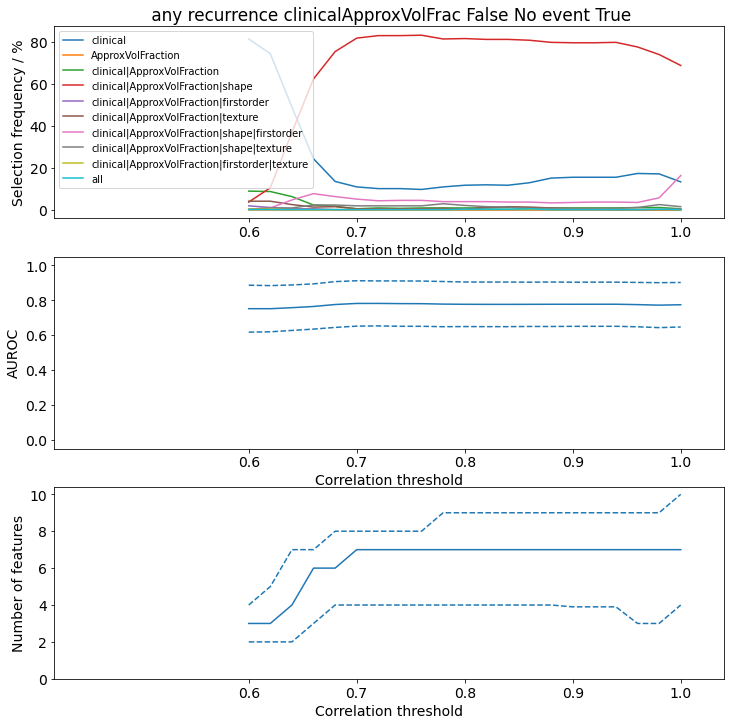

Threshold = 0.72
AUROC (CV) = 0.78223

Feature group = clinical|ApproxVolFraction|shape



Feature,Frequency,Coef
clinical_Grade,100.000,-0.926
lesion_original_shape_Sphericity,88.800,0.682
lesion_sarcomaFeature_highApproxVolFraction,83.800,-0.623
clinical_ECOG,82.200,-0.087
lesion_sarcomaFeature_calcApproxVolFraction,74.800,0.057
clinical_Size,64.000,0.052
lesion_original_shape_Flatness,61.200,-0.125
clinical_Subtype,53.000,0.011


train #      = 167 = 40 : 127 (24.0%)
train resub  = 0.837
train CV     = 0.782
test #       = 89 = 10 : 79 (11.2%)
test         = 0.666
test p-value = 0.09000389122603447


____________________
Failed experiments = 
[]


In [12]:
dfResults = None

failedExpID = []

for nExp, experiment in enumerate(experiments):

    # experiment settings
    target = experiment['target']
    featureSet = experiment['featureSet']
    rmTU = experiment['removeTargetUnknown']
    rpTU = experiment['replaceTargetUnknown']
    rmRX = experiment['removeRxPatients']
    
    print('Experiment number ' + str(nExp))
    zf = 12
    print('Target'.ljust(zf) + target)
    print('Features'.ljust(zf) + settingsDict[featureSet]['name'])
    print('Remove TU'.ljust(zf) + str(rmTU))
    print('Replace TU'.ljust(zf) + str(rpTU))
    print('Remove RX'.ljust(zf) + str(rmRX))

    try:
                
        df = prepData(dfClinical, dfRad, target, featureSet, removeTargetUnknown=rmTU, replaceTargetUnknown=rpTU, removeRxPatients=rmRX)
        dfTest = prepData(dfClinicalTest, dfRadTest, target, featureSet, removeTargetUnknown=rmTU, replaceTargetUnknown=rpTU, removeRxPatients=rmRX)

        fileName = '_'.join(['result', 
                             target,  
                             settingsDict[featureSet]['ID'],
                             str(rmTU),
                             str(rpTU),
                             str(rmRX)])
        quickLoadFile = os.path.join(outputFolder, fileName + '.pickle')

        modelFit = fitModelOrLoadSaved(df, target, settingsDict[featureSet], quickLoadFile)

        if displayAll:
            plotResultExperiments(modelFit, 
                                  titleStr=fileName.replace('result','').replace('_',' '),
                                  outputFile=os.path.join(outputFolder, 'figures', fileName + '.pdf'))

        bestCoef, pdFreq, bestThreshold, bestFeatureGroup = displayOneExperiment(modelFit)
        pdFreq = pdFreq.loc[pdFreq.Coef!='',:] # trim off any coeff that aren't in the best model
        display(pdFreq.style.hide_index())

        result = getTrainTestResults(modelFit)

        resultDict = experiment.copy()
        resultDict = dict(resultDict, **result)
        resultDict['threshold'] = bestThreshold
        resultDict['feature group'] = bestFeatureGroup
        resultDict['file name'] = fileName

        if dfResults is None:
            dfResults = pd.DataFrame([resultDict])
        else:
             dfResults = dfResults.append(resultDict, ignore_index=True)   

        dfResults.to_excel(os.path.join(outputFolder, 'results.xlsx'), index=False)
        
    except:
        print('FAILED')
        failedExpID.append(nExp)
        
    
    print('_'*20)

print('Failed experiments = ')
print(failedExpID)

## Re-save the copy of this notebook once it is completed

In [13]:
from IPython.display import display, Javascript
import time

# save current state of notebook and wait a bit as the actual save happens with a short delay
display(Javascript('IPython.notebook.save_checkpoint();'))
time.sleep(10)

# copy notebook to output folder
if saveOutputs:
    jupyterFile = os.path.join(os.path.abspath(""), 'LR_GroupSelection_withValidation_andOutcome_andClinical.ipynb')
    shutil.copyfile(jupyterFile, os.path.join(outputFolder, 'code', 'LR_GroupSelection_withValidation_andOutcome_andClinical.ipynb'))

<IPython.core.display.Javascript object>